# Load Packages

In [1]:
# Install required packages
!pip install --upgrade pip
!pip install tensorflow==2.15.0
!pip install pandas pillow matplotlib scikit-learn
!pip install pyunpack patool rarfile rioxarray opencv-python segmentation-models
!pip install numpy==1.26.4

# Install required packages
!pip install rasterio
!pip install geopandas
!pip install earthengine-api
!pip install geemap
!pip install sentinelhub
!pip install requests
!pip install scikit-image
!pip install shapely
!pip install pyproj
!pip install fiona
!pip install dotenv
!pip install download_sentinel2
!pip install openeo

# Download and install unrar binary
!wget https://www.rarlab.com/rar/rarlinux-x64-624.tar.gz
!tar -xzf rarlinux-x64-624.tar.gz
!sudo cp rar/unrar /usr/local/bin/
!sudo chmod +x /usr/local/bin/unrar

# Import packages
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'  # Use TensorFlow's Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16

import os
import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import PIL
import pathlib
import requests
import matplotlib.pyplot as plt
import sys
import cv2

from rarfile import RarFile
import segmentation_models as sm
from sklearn.metrics import *
import rioxarray as rxr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 88.9 MB/s  0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 57.3 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 216.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 168.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 54.3 MB/s  0:00:00
  Attempting uninstall: wrapt━━━━━━━━━━━━━━━━━━━  0/24 [libclang]
    Found existing installation: wrapt 2.0.0  0/24 [libclang]
    Uninstalling wrapt-2.0.0:━━━━━━━━━━━━━━━  0/24 [libclang]
      Successfully uninstalled wrapt-2.0.0━━  0/24 [libclan

2025-12-11 01:01:22.866030: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 01:01:23.045692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-11 01:01:23.045725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-11 01:01:23.046860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-11 01:01:23.054273: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `tf.keras` framework.


## Download masks from MapBiomas

In [18]:
# =============================================================================
# Indonesia Deforestation Detection - Download MapBiomas Data
# =============================================================================
# 
# This notebook downloads MapBiomas Indonesia land cover data for TWO regions:
#   1. Sumatra - Major palm oil deforestation area
#   2. Kalimantan (Borneo) - Significant forest loss region
#
# This mirrors the original paper's approach of comparing two biomes
# (sumatra vs Kalimantan Forest).
# =============================================================================

# Create directory structure
directories = [
    # MapBiomas data (ground truth masks)
    'data/mapbiomas/sumatra/raw',
    'data/mapbiomas/sumatra/processed',
    'data/mapbiomas/kalimantan/raw',
    'data/mapbiomas/kalimantan/processed',
    
    # Sentinel-2 data (satellite imagery)
    'data/sentinel2/sumatra/raw',
    'data/sentinel2/sumatra/processed',
    'data/sentinel2/kalimantan/raw',
    'data/sentinel2/kalimantan/processed',
    
    # Training/validation/test splits
    'data/sumatra/training/images',
    'data/sumatra/training/masks',
    'data/sumatra/validation/images',
    'data/sumatra/validation/masks',
    'data/sumatra/testing/images',
    'data/sumatra/testing/masks',
    
    'data/kalimantan/training/images',
    'data/kalimantan/training/masks',
    'data/kalimantan/validation/images',
    'data/kalimantan/validation/masks',
    'data/kalimantan/testing/images',
    'data/kalimantan/testing/masks',
    
    # Outputs
    'outputs',
    'models'
]

for d in directories:
    os.makedirs(d, exist_ok=True)
    
print("✓ Directory structure created!")
print("\nStructure:")
print("  data/")
print("  ├── mapbiomas/")
print("  │   ├── sumatra/      <- Ground truth masks")
print("  │   └── kalimantan/")
print("  ├── sentinel2/")
print("  │   ├── sumatra/      <- Satellite imagery")
print("  │   └── kalimantan/")
print("  ├── sumatra/          <- Processed training data")
print("  └── kalimantan/")

# Define MapBiomas Indonesia Download URLs
MAPBIOMAS_URLS = {
    'indonesia_full': {
        'url': 'https://storage.googleapis.com/mapbiomas-downloads/public/indonesia/maps/e3c1ad1e-2317-43c2-9c1a-7052fe5f3c5b/2022_coverage_lclu_4-1-1_e3c1ad1e-2317-43c2-9c1a-7052fe5f3c5b.tif',
        'filename': 'indonesia_2022_landcover.tif',
        'description': 'Full Indonesia land cover 2022'
    },
    'sumatra': {
        'url': 'https://storage.googleapis.com/mapbiomas-downloads/public/indonesia/maps/0a1975c8-1df2-4703-9867-3c0210e9f85a/2022_coverage_lclu_4-2-2_0a1975c8-1df2-4703-9867-3c0210e9f85a.tif',
        'filename': 'sumatra_2022_landcover.tif',
        'description': 'Sumatra land cover 2022'
    },
    'kalimantan': {
        'url': 'https://storage.googleapis.com/mapbiomas-downloads/public/indonesia/maps/ae3ceb93-4ad5-4907-9f81-81ce8288d189/2022_coverage_lclu_4-2-7_ae3ceb93-4ad5-4907-9f81-81ce8288d189.tif',
        'filename': 'kalimantan_2022_landcover.tif',
        'description': 'Kalimantan land cover 2022'
    }
}

print("MapBiomas Indonesia URLs configured:")
for region, info in MAPBIOMAS_URLS.items():
    print(f"\n  {region}:")
    print(f"    {info['description']}")

#Download Function
def download_file(url, output_path, description=""):
    """
    Download a file with progress bar.
    
    Parameters:
    -----------
    url : str
        URL to download
    output_path : str
        Path to save the file
    description : str
        Description for display
    """
    # Check if already exists
    if os.path.exists(output_path):
        size_mb = os.path.getsize(output_path) / (1024 * 1024)
        print(f"✓ Already downloaded: {os.path.basename(output_path)} ({size_mb:.1f} MB)")
        return output_path
    
    print(f"\nDownloading: {description or os.path.basename(output_path)}")
    print(f"URL: {url[:80]}...")
    
    try:
        response = requests.get(url, stream=True, timeout=60)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        
        if total_size > 0:
            print(f"Size: {total_size / (1024*1024):.1f} MB")
        
        # Ensure directory exists
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        with open(output_path, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc="Progress") as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    pbar.update(len(chunk))
        
        final_size = os.path.getsize(output_path) / (1024 * 1024)
        print(f"✓ Downloaded: {output_path} ({final_size:.1f} MB)")
        return output_path
        
    except requests.exceptions.HTTPError as e:
        print(f"✗ HTTP Error: {e}")
        return None
    except Exception as e:
        print(f"✗ Error: {e}")
        return None

# Download Sumatra and Kalimantan Data
print("="*70)
print("DOWNLOADING MAPBIOMAS INDONESIA DATA")
print("="*70)

downloaded_files = {}

# Download Sumatra
print("\n" + "-"*70)
print("REGION 1: SUMATRA")
print("-"*70)
sumatra_path = download_file(
    url=MAPBIOMAS_URLS['sumatra']['url'],
    output_path=f"data/mapbiomas/sumatra/raw/{MAPBIOMAS_URLS['sumatra']['filename']}",
    description=MAPBIOMAS_URLS['sumatra']['description']
)
downloaded_files['sumatra'] = sumatra_path

# Download Kalimantan
print("\n" + "-"*70)
print("REGION 2: KALIMANTAN")
print("-"*70)
kalimantan_path = download_file(
    url=MAPBIOMAS_URLS['kalimantan']['url'],
    output_path=f"data/mapbiomas/kalimantan/raw/{MAPBIOMAS_URLS['kalimantan']['filename']}",
    description=MAPBIOMAS_URLS['kalimantan']['description']
)
downloaded_files['kalimantan'] = kalimantan_path

# Summary
print("\n" + "="*70)
print("DOWNLOAD SUMMARY")
print("="*70)
for region, path in downloaded_files.items():
    if path and os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024*1024)
        print(f" {region.capitalize()}: {path} ({size_mb:.1f} MB)")
    else:
        print(f" {region.capitalize()}: Download failed")

# Inspect Downloaded Data
def inspect_geotiff(filepath, region_name):
    """Inspect a GeoTIFF file and print its properties."""
    try:
        import rasterio
        import numpy as np
        
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            return None
        
        with rasterio.open(filepath) as src:
            print(f"\n{'='*60}")
            print(f"{region_name.upper()} DATA INFO")
            print(f"{'='*60}")
            print(f"File: {os.path.basename(filepath)}")
            print(f"Dimensions: {src.width:,} x {src.height:,} pixels")
            print(f"Bands: {src.count}")
            print(f"Data type: {src.dtypes[0]}")
            print(f"CRS: {src.crs}")
            
            # Calculate approximate resolution in meters
            res_deg = abs(src.res[0])
            res_m = res_deg * 111000  # Approximate meters at equator
            print(f"Resolution: ~{res_m:.0f} meters")
            
            print(f"\nGeographic Bounds:")
            print(f"  West:  {src.bounds.left:.4f}°E")
            print(f"  East:  {src.bounds.right:.4f}°E")
            print(f"  South: {src.bounds.bottom:.4f}°")
            print(f"  North: {src.bounds.top:.4f}°")
            
            # Sample the data to find unique classes
            # Read a sample from the center
            center_row = src.height // 2
            center_col = src.width // 2
            sample_size = min(2000, src.width // 4, src.height // 4)
            
            window = rasterio.windows.Window(
                center_col - sample_size // 2,
                center_row - sample_size // 2,
                sample_size,
                sample_size
            )
            
            sample = src.read(1, window=window)
            unique_classes = np.unique(sample)
            
            print(f"\nLand Cover Classes (from center sample):")
            print(f"  Unique values: {unique_classes}")
            
            # Show distribution
            print(f"\n  Class distribution:")
            for cls in sorted(unique_classes):
                count = np.sum(sample == cls)
                pct = (count / sample.size) * 100
                if pct > 0.1:  # Only show classes with >0.1%
                    print(f"    Class {cls:2d}: {pct:5.1f}%")
            
            return {
                'width': src.width,
                'height': src.height,
                'crs': str(src.crs),
                'bounds': src.bounds,
                'resolution_m': res_m
            }
            
    except ImportError:
        print("Please install rasterio: pip install rasterio")
        return None
    except Exception as e:
        print(f"Error inspecting file: {e}")
        return None

# Inspect both files
sumatra_info = None
kalimantan_info = None

if downloaded_files.get('sumatra'):
    sumatra_info = inspect_geotiff(downloaded_files['sumatra'], 'Sumatra')

if downloaded_files.get('kalimantan'):
    kalimantan_info = inspect_geotiff(downloaded_files['kalimantan'], 'Kalimantan')

✓ Directory structure created!

Structure:
  data/
  ├── mapbiomas/
  │   ├── sumatra/      <- Ground truth masks
  │   └── kalimantan/
  ├── sentinel2/
  │   ├── sumatra/      <- Satellite imagery
  │   └── kalimantan/
  ├── sumatra/          <- Processed training data
  └── kalimantan/
MapBiomas Indonesia URLs configured:

  indonesia_full:
    Full Indonesia land cover 2022

  sumatra:
    Sumatra land cover 2022

  kalimantan:
    Kalimantan land cover 2022
DOWNLOADING MAPBIOMAS INDONESIA DATA

----------------------------------------------------------------------
REGION 1: SUMATRA
----------------------------------------------------------------------
✓ Already downloaded: sumatra_2022_landcover.tif (62.2 MB)

----------------------------------------------------------------------
REGION 2: KALIMANTAN
----------------------------------------------------------------------
✓ Already downloaded: kalimantan_2022_landcover.tif (52.9 MB)

DOWNLOAD SUMMARY
 Sumatra: data/mapbiomas/sumatra/

## Display Raw Masks

File: sumatra_2022_landcover.tif
Downsampled shape: (1894, 2196) (factor=24)
Target classes: [35]
Target pixels (downsampled): 198741 / 4159224  => 4.78%

Top classes in downsampled sample:
  Class   0:  3234506 pixels  (77.77%)
  Class  21:   258572 pixels  ( 6.22%)
  Class   3:   245414 pixels  ( 5.90%)
  Class  35:   198741 pixels  ( 4.78%)
  Class  13:    71988 pixels  ( 1.73%)
  Class  40:    41199 pixels  ( 0.99%)
  Class   9:    31814 pixels  ( 0.76%)
  Class  76:    27695 pixels  ( 0.67%)
  Class  24:    18614 pixels  ( 0.45%)
  Class   5:    12144 pixels  ( 0.29%)


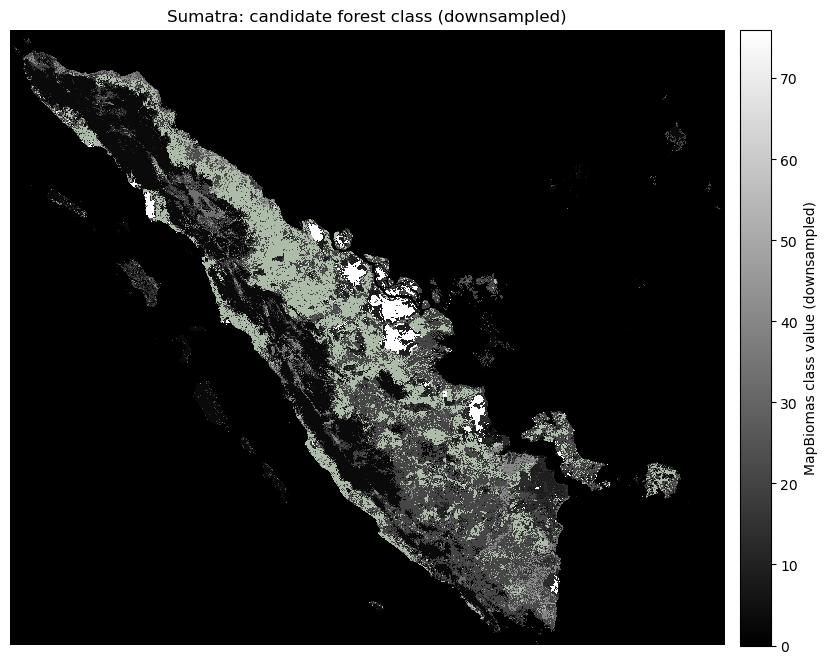

In [24]:
# Display MapBiomas landcover mask (Jupyter-friendly)
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap

def read_downsampled_band(path, downsample_factor=16, window=None):
    """
    Read band 1 downsampled by an integer factor to avoid huge memory use.
    - path: path to GeoTIFF
    - downsample_factor: integer factor to downsample each dimension (>=1)
    - window: rasterio.windows.Window if you want to read a specific tile (optional)
    Returns: (data, transform, bounds)
    """
    if downsample_factor < 1:
        raise ValueError("downsample_factor must be >= 1")
    with rasterio.open(path) as src:
        # If user provided a window, use it; else read the whole raster but request an out_shape
        if window is not None:
            # read a window at native resolution (smaller window)
            data = src.read(1, window=window)
            transform = src.window_transform(window)
            bounds = rasterio.windows.bounds(window, src.transform)
            return data, transform, bounds
        else:
            # compute a reduced shape
            out_height = int(src.height // downsample_factor) or 1
            out_width  = int(src.width  // downsample_factor) or 1
            out_shape = (out_height, out_width)
            data = src.read(
                1,
                out_shape=(out_shape[0], out_shape[1]),
                resampling=Resampling.nearest
            )
            # compute approximate transform for the downsampled array
            # scale transform by factor
            transform = src.transform * src.transform.scale(
                (src.width / data.shape[1]),
                (src.height / data.shape[0])
            )
            bounds = src.bounds
            return data, transform, bounds

def show_class_mask(path,
                    class_values,
                    downsample_factor=16,
                    cmap='Greens',
                    alpha=0.8,
                    show_counts=True,
                    title=None,
                    save_png=None):
    """
    Plot a binary mask where pixels are in class_values (int or list of ints).
    - path: path to GeoTIFF
    - class_values: int or list/tuple/np.array of ints representing target classes (e.g. [35])
    - downsample_factor: integer; increase to reduce memory / speed up plotting
    - cmap: matplotlib colormap name for mask
    - alpha: alpha for mask overlay
    - show_counts: prints counts and percent for the downsampled tile
    - title: optional plot title
    - save_png: if provided, saves figure to that path
    Returns: mask array and original downsampled raster (for further use)
    """
    if isinstance(class_values, (int, np.integer)):
        class_values = [int(class_values)]
    class_values = [int(x) for x in class_values]

    data, transform, bounds = read_downsampled_band(path, downsample_factor=downsample_factor)
    # Create boolean mask
    mask = np.isin(data, class_values)

    if show_counts:
        total = data.size
        target_count = mask.sum()
        print(f"File: {os.path.basename(path)}")
        print(f"Downsampled shape: {data.shape} (factor={downsample_factor})")
        print(f"Target classes: {class_values}")
        print(f"Target pixels (downsampled): {target_count} / {total}  => {100.0 * target_count / total:.2f}%")

        # show a small table of the most common classes in the downsampled tile
        unique, counts = np.unique(data, return_counts=True)
        order = np.argsort(-counts)
        print("\nTop classes in downsampled sample:")
        for i in order[:10]:
            print(f"  Class {unique[i]:3d}: {counts[i]:8d} pixels  ({100.0 * counts[i] / total:5.2f}%)")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(title or f"Mask for classes {class_values} — {os.path.basename(path)}", fontsize=12)

    # Show background as grayscale of the class indices (helps visualise distribution)
    img = ax.imshow(data, cmap='gray', interpolation='nearest', vmin=data.min(), vmax=data.max())
    cbar = fig.colorbar(img, ax=ax, fraction=0.04, pad=0.02)
    cbar.set_label('MapBiomas class value (downsampled)')

    # Overlay mask
    # build a colormap with transparent background
    if isinstance(cmap, str):
        base_cmap = plt.get_cmap(cmap)
    else:
        base_cmap = cmap
    # create an RGBA version of the colormap for mask overlay
    overlay_cmap = ListedColormap(base_cmap(np.linspace(0.2, 0.9, 1)))
    ax.imshow(np.ma.masked_where(~mask, mask), cmap=overlay_cmap, alpha=alpha, interpolation='nearest')

    ax.axis('off')
    if save_png:
        fig.savefig(save_png, bbox_inches='tight', dpi=200)
        print(f"Saved mask figure to {save_png}")
    plt.show()

    return mask, data

# Change this to the actual MapBiomas forest class id(s) if you know them (e.g., [35] or [21,35] etc.)
forest_classes = [35]

# Plot Sumatra with moderate downsampling (factor 24 => ~2k x ~2k for a 50k-wide raster)
# Reduce factor if you want higher detail, increase if memory is limited.
if 'sumatra_path' in globals() and sumatra_path:
    mask_suma, data_suma = show_class_mask(sumatra_path, forest_classes,
                                           downsample_factor=24,
                                           cmap='Greens',
                                           alpha=0.6,
                                           show_counts=True,
                                           title="Sumatra: candidate forest class (downsampled)",
                                           save_png=None)
else:
    print("Set sumatra_path to your file and re-run the cell, or call show_class_mask with the path.")


## Convert Masks to Binary Classification 1= forest, 0=not forest

✓ Forest mask saved to: data/mapbiomas/sumatra/processed/sumatra_forest_mask.tif


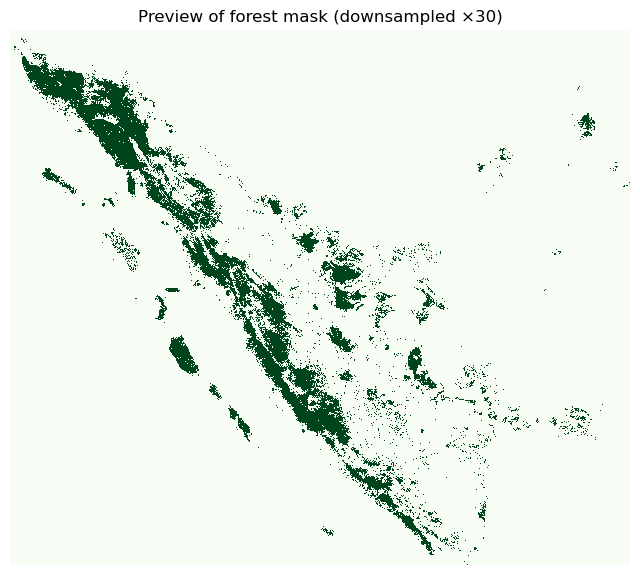

Value counts (downsampled):
  0: 2478136
  1: 182204
✓ Forest mask saved to: data/mapbiomas/kalimantan/processed/kalimantan_forest_mask.tif


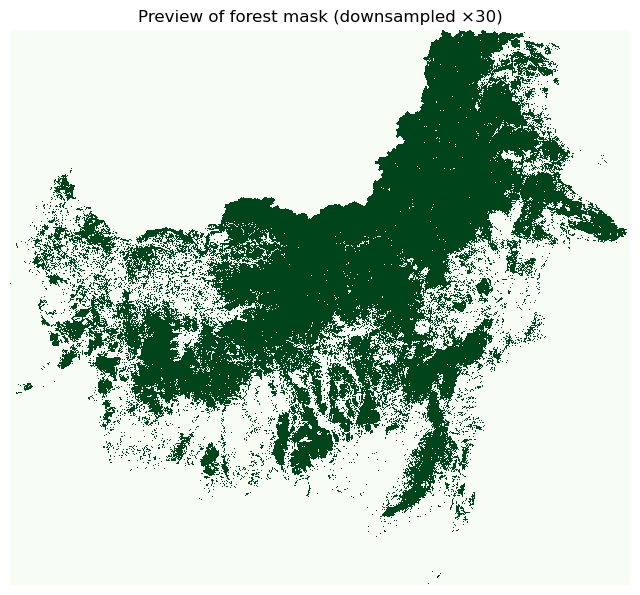

Value counts (downsampled):
  0: 1092211
  1: 402633


In [29]:
def create_forest_mask(input_tif, output_tif,
                       forest_classes=[3, 5, 76],
                       forest_value=1, nonforest_value=0):
    """
    Reclassify MapBiomas Indonesia land-cover raster into binary forest mask.
    Forest (classes 3,5,76) -> 1
    All others -> 0
    """

    with rasterio.open(input_tif) as src:
        profile = src.profile

        # Ensure output is simple uint8 mask
        profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

        with rasterio.open(output_tif, 'w', **profile) as dst:
            # Process block-by-block to avoid memory blow-up
            for ji, window in src.block_windows(1):
                data = src.read(1, window=window)

                mask = np.isin(data, forest_classes)
                out = np.where(mask, forest_value, nonforest_value).astype(np.uint8)

                dst.write(out, 1, window=window)

    print(f"✓ Forest mask saved to: {output_tif}")


def show_mask_preview(tif_path, downsample_factor=20):
    """
    Downsample and preview a binary mask.
    """
    with rasterio.open(tif_path) as src:
        out_h = src.height // downsample_factor
        out_w = src.width  // downsample_factor

        mask = src.read(
            1,
            out_shape=(out_h, out_w),
            resampling=Resampling.nearest
        )

    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='Greens', interpolation='nearest')
    plt.title(f"Preview of forest mask (downsampled ×{downsample_factor})")
    plt.axis('off')
    plt.show()

    unique, counts = np.unique(mask, return_counts=True)
    print("Value counts (downsampled):")
    for u, c in zip(unique, counts):
        print(f"  {u}: {c}")

# Input (yours)
sumatra_path = "data/mapbiomas/sumatra/raw/sumatra_2022_landcover.tif"
# Output mask file
sumatra_mask_out = "data/mapbiomas/sumatra/processed/sumatra_forest_mask.tif"
# Create mask Sumatra
create_forest_mask(sumatra_path, sumatra_mask_out)
# Show preview Sumatra
show_mask_preview(sumatra_mask_out, downsample_factor=30)

kalimantan_path = "data/mapbiomas/kalimantan/raw/kalimantan_2022_landcover.tif"
kalimantan_mask_out = "data/mapbiomas/kalimantan/processed/kalimantan_forest_mask.tif"
create_forest_mask(kalimantan_path, kalimantan_mask_out)
show_mask_preview(kalimantan_mask_out, downsample_factor=30)

# Download Sentinel-2 Satellite image data

In [36]:
# Authenticate to download data
import openeo
import datetime

# 1. Connect to the openEO back-end for CDSE
connection = openeo.connect("openeo.dataspace.copernicus.eu")
try:
    connection = connection.authenticate_oidc(max_poll_time=60, display=True)
    print("✅ Authentication successful")
except Exception as e:
    print(f"Authentication failed: {e}")

Authenticated using refresh token.
✅ Authentication successful


In [18]:
import openeo
import os
import openeo.processes as eop 

# Download Sumatra Data

# --- Configuration ---
temporal_extent = ["2022-01-01", "2022-12-31"]
bands_of_interest = ["B02", "B03", "B04", "B08"] 

# Define your Areas of Interest (use the same ones)
sumatra_aoi = {
    "west": 101.0, "south": -0.8,
    "east": 101.5, "north": -0.3
}
kalimantan_aoi = {
    "west": 113.5, "south": -1.5,
    "east": 114.0, "north": -1.0
}

# Output directories
sumatra_out_dir = 'data/sentinel2/sumatra/raw'
kalimantan_out_dir = 'data/sentinel2/kalimantan/raw'


def download_sentinel_composite_filtered_v4(connection, aoi, date_range, output_dir, file_name):
    """
    Final robust version: Uses chained logical OR operations on the SCL band 
    to create a reliable cloud-free median composite.
    """
    MAX_CLOUD_COVER = 10 
    
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\nProcessing {file_name} with chained logical OR filtering (Max scene cover: {MAX_CLOUD_COVER}%)...")
    
    try:
        # 1. Load the Sentinel-2 L2A collection (Science Bands: B02, B03, B04, B08)
        data_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=aoi,
            temporal_extent=date_range,
            bands=bands_of_interest, 
            max_cloud_cover=MAX_CLOUD_COVER    
        )
        
        # 2. Load the SCL band separately
        scl_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=aoi,
            temporal_extent=date_range,
            bands=["SCL"],
            max_cloud_cover=MAX_CLOUD_COVER
        )
        
        # 3. Create the mask logic by chaining OR operations (THE FIX)
        
        def create_cloud_mask_logic(scl_value):
            # Check for each cloud value using eop.eq
            mask_3 = eop.eq(scl_value, 3)  # Cloud Shadow
            mask_8 = eop.eq(scl_value, 8)  # Medium Cloud
            mask_9 = eop.eq(scl_value, 9)  # High Cloud
            mask_10 = eop.eq(scl_value, 10) # Cirrus

            # Chain the OR operations pairwise to avoid the list argument error
            is_cloud = eop.or_(eop.or_(mask_3, mask_8), eop.or_(mask_9, mask_10))
            return is_cloud

        # Apply the logic pixel-wise to the SCL time series
        boolean_mask = scl_cube.apply(process=create_cloud_mask_logic)
        
        # 4. Apply the mask to the data cube
        # Where boolean_mask is TRUE, the pixel in data_cube is set to NoData (None)
        masked_data_cube = data_cube.mask(mask=boolean_mask, replacement=None)

        # 5. Create a Cloud-Free Median Composite
        composite = masked_data_cube.reduce_dimension(dimension="t", reducer="median")
        
        # 6. Create and Run the Job
        print(" > Submitting batch job to cloud...")
        job = composite.create_job(
            out_format="GTiff",
            title=f"CloudFreeJob_{file_name}_V4"
        )
        
        job.start_and_wait()
        
        print(" > Downloading result...")
        job.get_results().download_files(output_dir)
        print(f"✅ Finished: Saved to {output_dir}")
        
    except Exception as e:
        print(f"❌ Error downloading {file_name}: {e}")

# Download Sumatra
download_sentinel_composite_filtered_v4(
    connection, 
    sumatra_aoi, 
    temporal_extent, 
    sumatra_out_dir,
    'sumatra_2022_cf_composite'
)


Processing sumatra_2022_cf_composite with chained logical OR filtering (Max scene cover: 10%)...
 > Submitting batch job to cloud...
0:00:00 Job 'j-251209205402476c95d645032f56649e': send 'start'
0:00:13 Job 'j-251209205402476c95d645032f56649e': created (progress 0%)
0:00:19 Job 'j-251209205402476c95d645032f56649e': created (progress 0%)
0:00:25 Job 'j-251209205402476c95d645032f56649e': running (progress N/A)
0:00:33 Job 'j-251209205402476c95d645032f56649e': running (progress N/A)
0:00:43 Job 'j-251209205402476c95d645032f56649e': running (progress N/A)
0:00:56 Job 'j-251209205402476c95d645032f56649e': running (progress N/A)
0:01:11 Job 'j-251209205402476c95d645032f56649e': running (progress N/A)
0:01:30 Job 'j-251209205402476c95d645032f56649e': running (progress N/A)
0:01:54 Job 'j-251209205402476c95d645032f56649e': running (progress N/A)
0:02:25 Job 'j-251209205402476c95d645032f56649e': running (progress N/A)
0:03:02 Job 'j-251209205402476c95d645032f56649e': running (progress N/A)
0:

In [20]:
import openeo
import os
import openeo.processes as eop 

# Download Kalimantan dataset with adjusted cloud filtering 
# (since there were no photos with 10% for 2022 due to high humidity in indonesia)

# Bands we want to keep, excluding SCL
bands_of_interest = ["B02", "B03", "B04", "B08"] 

# Define your Areas of Interest (use the same ones)
sumatra_aoi = {
    "west": 101.0, "south": -0.8,
    "east": 101.5, "north": -0.3
}
kalimantan_aoi = {
    "west": 113.5, "south": -1.5,
    "east": 114.0, "north": -1.0
}

# Output directories
sumatra_out_dir = 'data/sentinel2/sumatra/raw'
kalimantan_out_dir = 'data/sentinel2/kalimantan/raw'
temporal_extent = ["2022-01-01", "2022-12-31"]


def download_sentinel_composite_filtered_v5(connection, aoi, date_range, output_dir, file_name):
    """
    Revised for Kalimantan: Relaxed the initial scene-level cloud filter 
    to ensure data is found, while keeping the robust pixel-based masking.
    """
    # *** CHANGE IS HERE: Increased from 10 to 70 ***
    MAX_CLOUD_COVER = 70 
    
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\nProcessing {file_name} with robust cloud filtering (Max scene cover: {MAX_CLOUD_COVER}%)...")
    
    try:
        # 1. Load the Sentinel-2 L2A collection (Science Bands: B02, B03, B04, B08)
        data_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=aoi,
            temporal_extent=date_range,
            bands=bands_of_interest, 
            max_cloud_cover=MAX_CLOUD_COVER    
        )
        
        # 2. Load the SCL band separately
        scl_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=aoi,
            temporal_extent=date_range,
            bands=["SCL"],
            max_cloud_cover=MAX_CLOUD_COVER
        )
        
        # 3. Create the mask logic by chaining OR operations
        def create_cloud_mask_logic(scl_value):
            mask_3 = eop.eq(scl_value, 3)  # Cloud Shadow
            mask_8 = eop.eq(scl_value, 8)  # Medium Cloud
            mask_9 = eop.eq(scl_value, 9)  # High Cloud
            mask_10 = eop.eq(scl_value, 10) # Cirrus

            # Chain the OR operations pairwise
            is_cloud = eop.or_(eop.or_(mask_3, mask_8), eop.or_(mask_9, mask_10))
            return is_cloud

        # Apply the logic pixel-wise to the SCL time series
        boolean_mask = scl_cube.apply(process=create_cloud_mask_logic)
        
        # 4. Apply the mask to the data cube
        masked_data_cube = data_cube.mask(mask=boolean_mask, replacement=None)

        # 5. Create a Cloud-Free Median Composite
        composite = masked_data_cube.reduce_dimension(dimension="t", reducer="median")
        
        # 6. Create and Run the Job
        print(" > Submitting batch job to cloud...")
        job = composite.create_job(
            out_format="GTiff",
            title=f"CloudFreeJob_{file_name}_V5"
        )
        
        job.start_and_wait()
        
        print(" > Downloading result...")
        job.get_results().download_files(output_dir)
        print(f"✅ Finished: Saved to {output_dir}")
        
    except Exception as e:
        print(f"❌ Error downloading {file_name}: {e}")


# Download Kalimantan
download_sentinel_composite_filtered_v5(
    connection, 
    kalimantan_aoi, 
    temporal_extent, 
    kalimantan_out_dir,
    'kalimantan_2022_cf_composite'
)


Processing kalimantan_2022_cf_composite with robust cloud filtering (Max scene cover: 70%)...
 > Submitting batch job to cloud...
0:00:00 Job 'j-25120921031044f3904cf19a63185212': send 'start'
0:00:14 Job 'j-25120921031044f3904cf19a63185212': created (progress 0%)
0:00:20 Job 'j-25120921031044f3904cf19a63185212': created (progress 0%)
0:00:27 Job 'j-25120921031044f3904cf19a63185212': created (progress 0%)
0:00:35 Job 'j-25120921031044f3904cf19a63185212': created (progress 0%)
0:00:45 Job 'j-25120921031044f3904cf19a63185212': created (progress 0%)
0:00:57 Job 'j-25120921031044f3904cf19a63185212': running (progress N/A)
0:01:13 Job 'j-25120921031044f3904cf19a63185212': running (progress N/A)
0:01:32 Job 'j-25120921031044f3904cf19a63185212': running (progress N/A)
0:01:56 Job 'j-25120921031044f3904cf19a63185212': running (progress N/A)
0:02:27 Job 'j-25120921031044f3904cf19a63185212': running (progress N/A)
0:03:04 Job 'j-25120921031044f3904cf19a63185212': running (progress N/A)
0:03:51 

## Visualise downloaded Satellite Imagery

VISUALIZING SUMATRA COMPOSITE
✅ Found GeoTIFF file for Sumatra: openEO.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

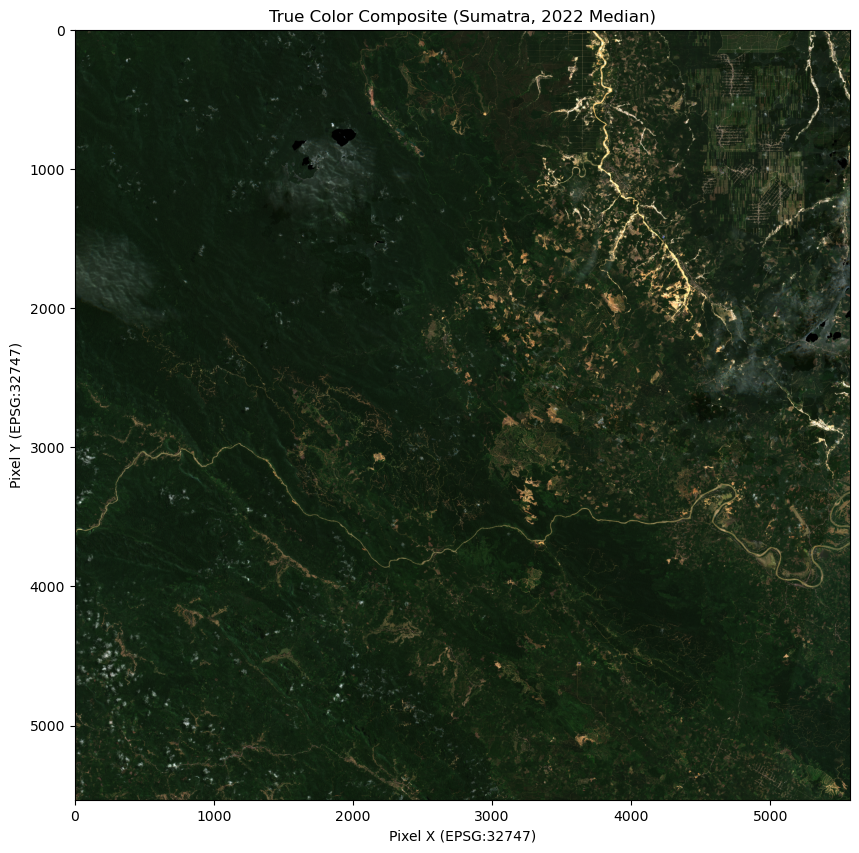


Image Shape (H, W, C): (5534, 5571, 3)
CRS: EPSG:32747
Bounds: (722570.0, 9911490.0, 778280.0, 9966830.0)
--------------------------------------------------

VISUALIZING KALIMANTAN COMPOSITE
✅ Found GeoTIFF file for Kalimantan: openEO.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

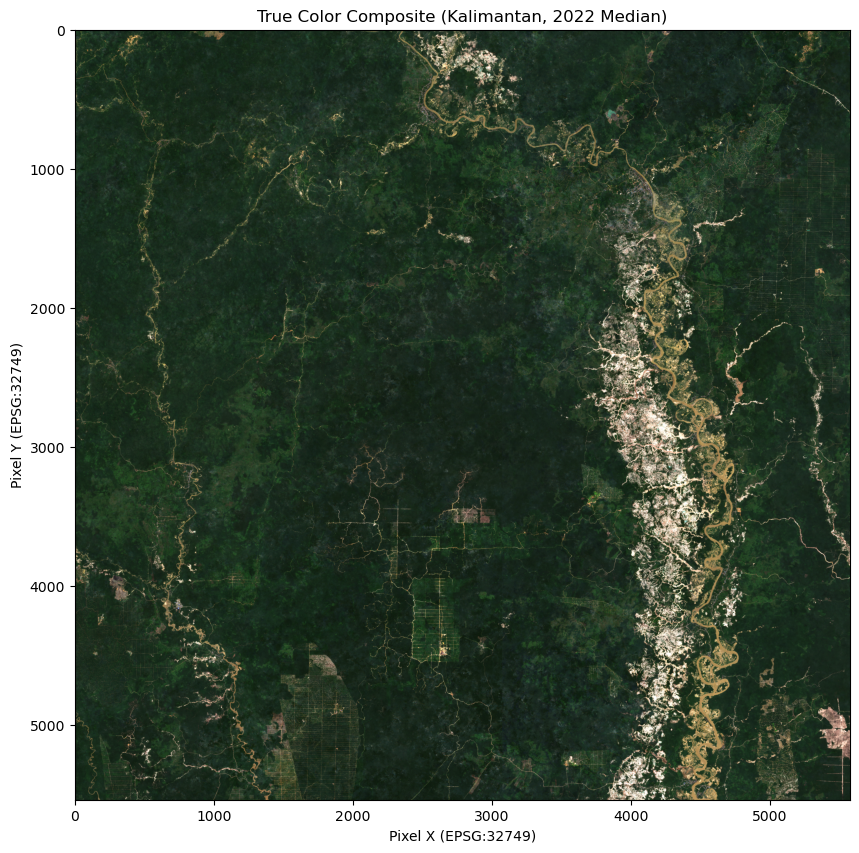


Image Shape (H, W, C): (5540, 5575, 3)
CRS: EPSG:32749
Bounds: (778180.0, 9833970.0, 833930.0, 9889370.0)
--------------------------------------------------


In [9]:
# Visualise satelite images to check for quality
import glob

def visualize_sentinel2_composite(region_name):
    """
    Finds the first downloaded GeoTIFF for a region, reads the RGB bands,
    and displays a true-color composite.
    """
    
    # 1. Define the input directory
    data_dir = f'data/sentinel2/{region_name}/raw'
    
    # 2. Find the downloaded file (it might have a generic or job-id name)
    # Searches for the first file ending with .tif or .tiff in the directory
    try:
        tiff_path = glob.glob(os.path.join(data_dir, '*.tif*'))[0]
        print(f"✅ Found GeoTIFF file for {region_name.capitalize()}: {os.path.basename(tiff_path)}")
    except IndexError:
        print(f"❌ Error: Could not find any .tif or .tiff file in the directory: {data_dir}")
        print("Please check the output directory for the exact file name and update 'tiff_path'.")
        return

    # 3. Read the data using rioxarray
    # It loads all 4 bands: B02, B03, B04, B08 (Blue, Green, Red, NIR)
    try:
        data = rxr.open_rasterio(tiff_path)
    except Exception as e:
        print(f"❌ Error reading file with rioxarray: {e}")
        return

    # Check for the expected number of bands (4)
    if data.shape[0] < 4:
        print(f"❌ Error: Expected 4 bands (B02, B03, B04, B08), but found {data.shape[0]} bands.")
        print("Bands must be in the order: [Blue, Green, Red, NIR]")
        return
        
    # Our downloaded bands were ordered as: [B02, B03, B04, B08]
    # We need to stack them as [R, G, B] for display, which are indices [2, 1, 0]
    
    # Extract R, G, B bands and transpose to (Height, Width, Channel) format
    # R (index 2), G (index 1), B (index 0)
    rgb_img = np.dstack((data[2].values, data[1].values, data[0].values))

    # 4. Normalize the image data for display (Sentinal-2 max value is typically around 10000)
    # We clip outliers and scale the values to the 0-1 range expected by matplotlib
    def normalize_band(band_array, max_val=3000):
        # Clip values to prevent white spots from cloud remnants or high reflectance
        band_array = np.clip(band_array, 0, max_val)
        # Scale to 0-1
        return band_array / max_val

    # Apply normalization to the stacked RGB image
    # Note: We must apply it to the 3 channels separately
    normalized_img = np.zeros_like(rgb_img, dtype=np.float32)
    normalized_img[:, :, 0] = normalize_band(rgb_img[:, :, 0])  # Red
    normalized_img[:, :, 1] = normalize_band(rgb_img[:, :, 1])  # Green
    normalized_img[:, :, 2] = normalize_band(rgb_img[:, :, 2])  # Blue

    # 5. Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(normalized_img)
    plt.title(f"True Color Composite ({region_name.capitalize()}, 2022 Median)")
    plt.xlabel(f"Pixel X ({data.rio.crs})")
    plt.ylabel(f"Pixel Y ({data.rio.crs})")
    plt.show()
    
    # Display coordinates and shape
    print(f"\nImage Shape (H, W, C): {normalized_img.shape}")
    print(f"CRS: {data.rio.crs}")
    print(f"Bounds: {data.rio.bounds()}")
    print("-" * 50)
    
    return normalized_img, data.rio.bounds()

# --- Run the visualization for Sumatra ---
print("=" * 50)
print("VISUALIZING SUMATRA COMPOSITE")
print("=" * 50)
sumatra_image, sumatra_bounds = visualize_sentinel2_composite('sumatra')

# --- Run the visualization for Kalimantan (if you downloaded it) ---
# Uncomment the following lines once your Kalimantan job is finished
print("\n" + "=" * 50)
print("VISUALIZING KALIMANTAN COMPOSITE")
print("=" * 50)
kalimantan_image, kalimantan_bounds = visualize_sentinel2_composite('kalimantan')

✅ Found file: openEO.tif


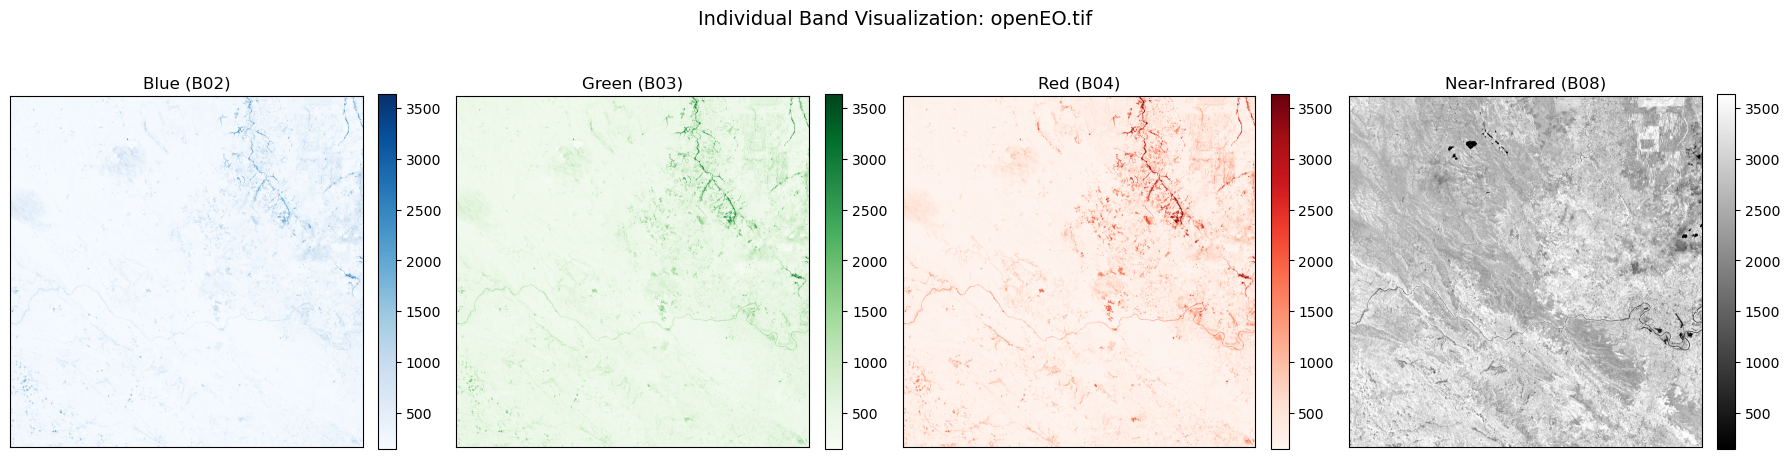

✅ Found file: openEO.tif


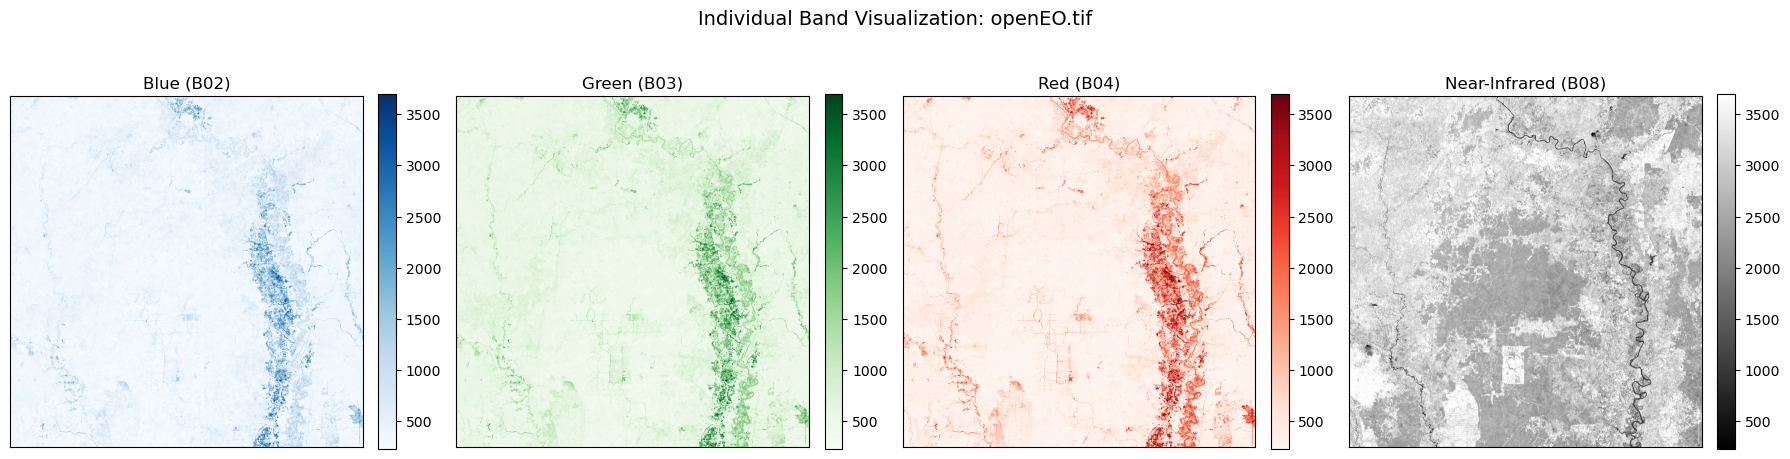

In [12]:
# Display satellite image with individual bands
import rasterio
# Directory where the Sumatra file was saved
data_dir = 'data/sentinel2/sumatra/raw'
data_dir2 = 'data/sentinel2/kalimantan/raw'

def visualize_single_bands_rasterio(data_dir):
    """
    Finds the newest GeoTIFF and plots each of the four bands (B, G, R, NIR) 
    using rasterio and matplotlib.
    """
    # 1. Find the newest downloaded file
    try:
        list_of_files = glob.glob(os.path.join(data_dir, '*.tif*'))
        if not list_of_files:
            print("❌ Error: Could not find any GeoTIFF file in the directory.")
            return
            
        tiff_path = max(list_of_files, key=os.path.getctime) 
        print(f"✅ Found file: {os.path.basename(tiff_path)}")
    except IndexError:
        print(f"❌ Error: Could not find any .tif or .tiff file in the directory: {data_dir}")
        return

    # 2. Open the file with rasterio
    try:
        with rasterio.open(tiff_path) as src:
            if src.count < 4:
                print(f"❌ Error: Expected 4 bands, but found {src.count} bands.")
                return
            
            # Read all bands (B02, B03, B04, B08)
            all_bands = src.read()
            
            # Define band labels
            bands = {
                0: {"name": "Blue (B02)", "color": "Blues"},
                1: {"name": "Green (B03)", "color": "Greens"},
                2: {"name": "Red (B04)", "color": "Reds"},
                3: {"name": "Near-Infrared (B08)", "color": "Greys"}
            }
            
            fig, axes = plt.subplots(1, 4, figsize=(18, 5))
            fig.suptitle(f"Individual Band Visualization: {os.path.basename(tiff_path)}", fontsize=14)
            
            # Get the global min/max data range for consistent visualization scale
            valid_data = all_bands[~np.isnan(all_bands)]
            v_min = np.percentile(valid_data, 2) if valid_data.size > 0 else 0
            v_max = np.percentile(valid_data, 98) if valid_data.size > 0 else 3000

            # 3. Loop and plot each band
            for i in range(4):
                band_data = all_bands[i]
                ax = axes[i]
                
                # Use band-appropriate or generic grayscale colormap
                cmap = bands[i]["color"] if i < 3 else 'gray'
                
                # Plot the band
                im = ax.imshow(band_data, cmap=cmap, vmin=v_min, vmax=v_max)
                
                ax.set_title(bands[i]["name"])
                ax.set_xticks([])
                ax.set_yticks([])
                
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    except Exception as e:
        print(f"❌ Error processing file: {e}")

# Run the visualization for Sumatra
visualize_single_bands_rasterio(data_dir)
visualize_single_bands_rasterio(data_dir2)

## Data Preparation

In [5]:
# Run this in your notebook to check overlap
import rasterio

with rasterio.open('data/sentinel2/sumatra/raw/openEO.tif') as img:
    print(f"Image bounds: {img.bounds}")
    print(f"Image CRS: {img.crs}")
    print(f"Image shape: {img.width} x {img.height}")

with rasterio.open('data/mapbiomas/sumatra/raw/sumatra_2022_landcover.tif') as mask:
    print(f"Mask bounds: {mask.bounds}")
    print(f"Mask CRS: {mask.crs}")
    print(f"Mask shape: {mask.width} x {mask.height}")

Image bounds: BoundingBox(left=722570.0, bottom=9911490.0, right=778280.0, top=9966830.0)
Image CRS: EPSG:32747
Image shape: 5571 x 5534
Mask bounds: BoundingBox(left=94.96719689126346, bottom=-6.172773474827293, right=109.17171748987498, top=6.081414810432337)
Mask CRS: EPSG:4326
Mask shape: 52708 x 45471


In [3]:
"""
COMPLETE DATA PREPARATION PIPELINE
===================================
This will:
1. Reproject the mask from EPSG:4326 (degrees) to EPSG:32747 (meters)
2. Clip the mask to match satellite image extent
3. Tile both into aligned 512x512 patches
4. Split into train/validation/test sets
"""

import subprocess
subprocess.run(['pip', 'install', 'shapely', '-q'])

import os
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
from rasterio.mask import mask as rasterio_mask
from shapely.geometry import box
import json
import random
from pathlib import Path
from scipy.ndimage import zoom

# Configuration
PATCH_SIZE = 512
FOREST_CLASSES = [3, 4, 5, 6]  # MapBiomas Indonesia forest classes

def create_binary_forest_mask(landcover_array):
    """Convert land cover classes to binary forest/non-forest."""
    return np.isin(landcover_array, FOREST_CLASSES).astype(np.uint8)

def reproject_and_clip_mask(mask_path, image_path, output_dir):
    """
    STEP 1: Reproject mask to match image CRS and clip to image extent.
    """
    print("\n" + "="*70)
    print("STEP 1: REPROJECTING AND CLIPPING MASK")
    print("="*70)
    
    # Get image properties
    with rasterio.open(image_path) as img_src:
        img_crs = img_src.crs
        img_bounds = img_src.bounds
        img_res = img_src.res
        img_width = img_src.width
        img_height = img_src.height
        
        print(f"\nImage (Sentinel-2):")
        print(f"  CRS: {img_crs}")
        print(f"  Size: {img_width} x {img_height} pixels")
        print(f"  Resolution: {img_res[0]:.1f} m")
        print(f"  Bounds: {img_bounds}")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    reprojected_path = os.path.join(output_dir, 'mask_reprojected.tif')
    clipped_path = os.path.join(output_dir, 'mask_clipped.tif')
    
    # Open and reproject mask
    with rasterio.open(mask_path) as mask_src:
        print(f"\nMask (MapBiomas):")
        print(f"  CRS: {mask_src.crs}")
        print(f"  Size: {mask_src.width} x {mask_src.height} pixels")
        print(f"  Bounds: {mask_src.bounds}")
        
        print(f"\nReprojecting mask from {mask_src.crs} to {img_crs}...")
        print("(This may take a few minutes for large masks...)")
        
        transform, width, height = calculate_default_transform(
            mask_src.crs,
            img_crs,
            mask_src.width,
            mask_src.height,
            *mask_src.bounds,
            resolution=img_res
        )
        
        kwargs = mask_src.meta.copy()
        kwargs.update({
            'crs': img_crs,
            'transform': transform,
            'width': width,
            'height': height,
            'compress': 'lzw'
        })
        
        with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(mask_src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=mask_src.transform,
                src_crs=mask_src.crs,
                dst_transform=transform,
                dst_crs=img_crs,
                resampling=Resampling.nearest
            )
    
    print(f"✓ Reprojected mask saved: {reprojected_path}")
    
    # Now clip to image extent
    print(f"\nClipping mask to image extent...")
    
    with rasterio.open(reprojected_path) as reprojected_mask:
        print(f"  Reprojected mask bounds: {reprojected_mask.bounds}")
        print(f"  Image bounds: {img_bounds}")
        
        clip_geom = box(img_bounds.left, img_bounds.bottom, 
                       img_bounds.right, img_bounds.top)
        
        mask_box = box(reprojected_mask.bounds.left, reprojected_mask.bounds.bottom,
                      reprojected_mask.bounds.right, reprojected_mask.bounds.top)
        
        if not clip_geom.intersects(mask_box):
            print("❌ ERROR: Image and mask do not overlap!")
            return None
        
        intersection = clip_geom.intersection(mask_box)
        print(f"  Intersection area: {intersection.area/1e6:.2f} km²")
        
        # FIXED: Remove fill_value argument (not supported in all rasterio versions)
        clipped_data, clipped_transform = rasterio_mask(
            reprojected_mask,
            [json.loads(json.dumps(clip_geom.__geo_interface__))],
            crop=True,
            filled=True
        )
        
        clipped_meta = reprojected_mask.meta.copy()
        clipped_meta.update({
            'height': clipped_data.shape[1],
            'width': clipped_data.shape[2],
            'transform': clipped_transform
        })
        
        with rasterio.open(clipped_path, 'w', **clipped_meta) as dst:
            dst.write(clipped_data)
    
    with rasterio.open(clipped_path) as clipped:
        print(f"\n✓ Clipped mask saved: {clipped_path}")
        print(f"  Size: {clipped.width} x {clipped.height} pixels")
        print(f"  CRS: {clipped.crs}")
        
        sample = clipped.read(1)
        unique_vals = np.unique(sample)
        print(f"  Land cover classes present: {unique_vals}")
        
        forest_pixels = np.isin(sample, FOREST_CLASSES).sum()
        total_pixels = sample.size
        print(f"  Forest coverage: {forest_pixels/total_pixels:.1%}")
    
    return clipped_path


def tile_data(image_path, mask_path, output_dir, region_name, 
              min_valid=0.7, min_forest=0.01):
    """
    STEP 2: Tile image and mask into 512x512 patches.
    """
    print("\n" + "="*70)
    print("STEP 2: TILING DATA INTO 512x512 PATCHES")
    print("="*70)
    
    base = Path(output_dir) / region_name
    for split in ['training', 'validation', 'testing']:
        (base / split / 'images').mkdir(parents=True, exist_ok=True)
        (base / split / 'masks').mkdir(parents=True, exist_ok=True)
    
    patches = []
    stats = {'total': 0, 'valid': 0, 'skipped_nodata': 0, 
             'skipped_forest': 0, 'forest_ratios': []}
    
    with rasterio.open(image_path) as img:
        with rasterio.open(mask_path) as msk:
            print(f"\nImage: {img.width} x {img.height}, CRS: {img.crs}")
            print(f"Mask:  {msk.width} x {msk.height}, CRS: {msk.crs}")
            
            if str(img.crs) != str(msk.crs):
                print(f"❌ CRS mismatch! Image: {img.crs}, Mask: {msk.crs}")
                return None
            
            print("✓ CRS matches!")
            
            n_cols = min(img.width, msk.width) // PATCH_SIZE
            n_rows = min(img.height, msk.height) // PATCH_SIZE
            
            print(f"\nPatch grid: {n_rows} rows × {n_cols} cols = {n_rows * n_cols} patches")
            
            patch_id = 0
            for row in range(n_rows):
                for col in range(n_cols):
                    stats['total'] += 1
                    
                    window = Window(col * PATCH_SIZE, row * PATCH_SIZE,
                                   PATCH_SIZE, PATCH_SIZE)
                    
                    try:
                        img_patch = img.read(window=window)
                        msk_patch = msk.read(1, window=window)
                    except Exception as e:
                        stats['skipped_nodata'] += 1
                        continue
                    
                    valid_ratio = np.mean(~np.all(img_patch == 0, axis=0))
                    if valid_ratio < min_valid:
                        stats['skipped_nodata'] += 1
                        continue
                    
                    binary_mask = create_binary_forest_mask(msk_patch)
                    
                    forest_ratio = binary_mask.mean()
                    if forest_ratio < min_forest or forest_ratio > (1 - min_forest):
                        stats['skipped_forest'] += 1
                        continue
                    
                    stats['valid'] += 1
                    stats['forest_ratios'].append(forest_ratio)
                    
                    patches.append({
                        'id': patch_id,
                        'img': img_patch,
                        'mask': binary_mask,
                        'forest': forest_ratio
                    })
                    patch_id += 1
                    
                    if patch_id % 10 == 0:
                        print(f"  Found {patch_id} valid patches...")
    
    if not patches:
        print("\n❌ No valid patches found!")
        return stats
    
    random.shuffle(patches)
    n_train = int(len(patches) * 0.70)
    n_val = int(len(patches) * 0.15)
    
    splits = {
        'training': patches[:n_train],
        'validation': patches[n_train:n_train + n_val],
        'testing': patches[n_train + n_val:]
    }
    
    print(f"\nSaving {len(patches)} patches...")
    for split_name, split_patches in splits.items():
        for p in split_patches:
            img_file = base / split_name / 'images' / f"{region_name}_{p['id']:05d}.tif"
            with rasterio.open(img_file, 'w', driver='GTiff', 
                              height=PATCH_SIZE, width=PATCH_SIZE,
                              count=p['img'].shape[0], dtype=p['img'].dtype,
                              compress='lzw') as dst:
                dst.write(p['img'])
            
            msk_file = base / split_name / 'masks' / f"{region_name}_{p['id']:05d}.tif"
            with rasterio.open(msk_file, 'w', driver='GTiff',
                              height=PATCH_SIZE, width=PATCH_SIZE,
                              count=1, dtype='uint8', compress='lzw') as dst:
                dst.write(p['mask'][np.newaxis, ...])
    
    print("\n" + "="*70)
    print(f"COMPLETE - {region_name.upper()}")
    print("="*70)
    print(f"Total examined: {stats['total']}")
    print(f"Valid patches:  {stats['valid']}")
    print(f"Skipped (no data): {stats['skipped_nodata']}")
    print(f"Skipped (forest ratio): {stats['skipped_forest']}")
    print(f"\nSplits:")
    print(f"  Training:   {len(splits['training'])}")
    print(f"  Validation: {len(splits['validation'])}")
    print(f"  Testing:    {len(splits['testing'])}")
    
    if stats['forest_ratios']:
        print(f"\nForest coverage in patches: {np.mean(stats['forest_ratios']):.1%} avg")
    
    return stats


def prepare_region(region_name, image_path, mask_path):
    """Complete pipeline for one region."""
    print("\n" + "#"*70)
    print(f"# PREPARING: {region_name.upper()}")
    print("#"*70)
    
    processed_dir = f'data/mapbiomas/{region_name}/processed'
    clipped_mask = reproject_and_clip_mask(mask_path, image_path, processed_dir)
    
    if clipped_mask is None:
        print("❌ Failed at Step 1")
        return None
    
    stats = tile_data(image_path, clipped_mask, 'data', region_name)
    
    return stats


# ============================================================
# RUN THE PIPELINE
# ============================================================

print("="*70)
print("INDONESIA DEFORESTATION DATA PREPARATION")
print("="*70)

sumatra_stats = prepare_region(
    region_name='sumatra',
    image_path='data/sentinel2/sumatra/raw/openEO.tif',
    mask_path='data/mapbiomas/sumatra/raw/sumatra_2022_landcover.tif'
)

print("\n\n" + "="*70)
print("ALL DONE!")
print("="*70)
print("\nYour patches are in:")
print("  data/sumatra/training/images/")
print("  data/sumatra/training/masks/")
print("  data/sumatra/validation/images/")
print("  data/sumatra/validation/masks/")
print("  data/sumatra/testing/images/")
print("  data/sumatra/testing/masks/")

INDONESIA DEFORESTATION DATA PREPARATION

######################################################################
# PREPARING: SUMATRA
######################################################################

STEP 1: REPROJECTING AND CLIPPING MASK

Image (Sentinel-2):
  CRS: EPSG:32747
  Size: 5571 x 5534 pixels
  Resolution: 10.0 m
  Bounds: BoundingBox(left=722570.0, bottom=9911490.0, right=778280.0, top=9966830.0)

Mask (MapBiomas):
  CRS: EPSG:4326
  Size: 52708 x 45471 pixels
  Bounds: BoundingBox(left=94.96719689126346, bottom=-6.172773474827293, right=109.17171748987498, top=6.081414810432337)

Reprojecting mask from EPSG:4326 to EPSG:32747...
(This may take a few minutes for large masks...)
✓ Reprojected mask saved: data/mapbiomas/sumatra/processed/mask_reprojected.tif

Clipping mask to image extent...
  Reprojected mask bounds: BoundingBox(left=50876.631238500646, bottom=9306799.293568363, right=1637896.6312385006, top=10682929.293568363)
  Image bounds: BoundingBox(left=722570.0

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(



COMPLETE - SUMATRA
Total examined: 100
Valid patches:  71
Skipped (no data): 0
Skipped (forest ratio): 29

Splits:
  Training:   49
  Validation: 10
  Testing:    12

Forest coverage in patches: 56.6% avg


ALL DONE!

Your patches are in:
  data/sumatra/training/images/
  data/sumatra/training/masks/
  data/sumatra/validation/images/
  data/sumatra/validation/masks/
  data/sumatra/testing/images/
  data/sumatra/testing/masks/


In [5]:
sumatra_stats = prepare_region(
    region_name='kalimantan',
    image_path='data/sentinel2/kalimantan/raw/openEO.tif',
    mask_path='data/mapbiomas/kalimantan/raw/kalimantan_2022_landcover.tif'
)


######################################################################
# PREPARING: KALIMANTAN
######################################################################

STEP 1: REPROJECTING AND CLIPPING MASK

Image (Sentinel-2):
  CRS: EPSG:32749
  Size: 5575 x 5540 pixels
  Resolution: 10.0 m
  Bounds: BoundingBox(left=778180.0, bottom=9833970.0, right=833930.0, top=9889370.0)

Mask (MapBiomas):
  CRS: EPSG:4326
  Size: 38768 x 34734 pixels
  Bounds: BoundingBox(left=108.5939210991293, bottom=-4.947381595759852, right=119.04168717955298, top=4.413243327822386)

Reprojecting mask from EPSG:4326 to EPSG:32749...
(This may take a few minutes for large masks...)
✓ Reprojected mask saved: data/mapbiomas/kalimantan/processed/mask_reprojected.tif

Clipping mask to image extent...
  Reprojected mask bounds: BoundingBox(left=232184.4093002961, bottom=9447713.695869794, right=1397814.409300296, top=10492663.695869794)
  Image bounds: BoundingBox(left=778180.0, bottom=9833970.0, right=833930.0, t

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(



COMPLETE - KALIMANTAN
Total examined: 100
Valid patches:  97
Skipped (no data): 0
Skipped (forest ratio): 3

Splits:
  Training:   67
  Validation: 14
  Testing:    16

Forest coverage in patches: 50.5% avg


## Download more data

In [39]:
import openeoO
import os
import openeo.processes as eop
from typing import Dict, List

# --- Configuration from your original script ---

# Bands we want to keep, excluding SCL
bands_of_interest = ["B02", "B03", "B04", "B08"]

# Output directories (Using a general structure for the new AOIs)
BASE_OUT_DIR = 'data/sentinel2' # Change this base path if needed
temporal_extent = ["2022-01-01", "2022-12-31"]
MAX_CLOUD_COVER = 70 # Retained from your revised function

# --- Your Download Function (Slightly modified to remove MAX_CLOUD_COVER from arguments) ---

def download_sentinel_composite_filtered_v5(connection, aoi_data: Dict, date_range: List[str], base_output_dir: str):
    """
    Revised for robust cloud filtering:
    1. Uses a relaxed scene-level cloud filter (MAX_CLOUD_COVER).
    2. Applies robust pixel-based masking using SCL band for Cloud Shadow, Medium/High Cloud, and Cirrus.
    3. Creates a cloud-free Median Composite.
    """
    
    aoi_name = aoi_data["name"]O
    aoi_coords = {k: aoi_data[k] for k in ["west", "south", "east", "north"]}
    
    # Determine output path based on AOI name (e.g., 'data/sentinel2/sumatra_riau_north/raw')
    output_dir = os.path.join(base_output_dir, aoi_name, 'raw')
    
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\nProcessing **{aoi_name}** with robust cloud filtering (Max scene cover: {MAX_CLOUD_COVER}%)...")
    
    try:
        # 1. Load the Sentinel-2 L2A collection (Science Bands)
        data_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=aoi_coords,
            temporal_extent=date_range,
            bands=bands_of_interest,
            max_cloud_cover=MAX_CLOUD_COVER 
        )
        
        # 2. Load the SCL band separately
        scl_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=aoi_coords,
            temporal_extent=date_range,
            bands=["SCL"],
            max_cloud_cover=MAX_CLOUD_COVER
        )
        
        # 3. Create the mask logic by chaining OR operations (Pixel-wise mask)
        def create_cloud_mask_logic(scl_value):
            # 3: Cloud Shadow, 8: Medium Cloud, 9: High Cloud, 10: Cirrus
            mask_3 = eop.eq(scl_value, 3)
            mask_8 = eop.eq(scl_value, 8)
            mask_9 = eop.eq(scl_value, 9)
            mask_10 = eop.eq(scl_value, 10)

            # Chain the OR operations: (3 OR 8) OR (9 OR 10)
            is_cloud = eop.or_(eop.or_(mask_3, mask_8), eop.or_(mask_9, mask_10))
            return is_cloud

        # Apply the logic pixel-wise to the SCL time series
        boolean_mask = scl_cube.apply(process=create_cloud_mask_logic)
        
        # 4. Apply the mask to the data cube (replace cloud/shadow pixels with 'None'/NoData)
        masked_data_cube = data_cube.mask(mask=boolean_mask, replacement=None)

        # 5. Create a Cloud-Free Median Composite
        composite = masked_data_cube.reduce_dimension(dimension="t", reducer="median")
        
        # 6. Create and Run the Job
        print(" > Submitting batch job to cloud...")
        job = composite.create_job(
            out_format="GTiff",
            title=f"CloudFreeJob_{aoi_name}_V5"
        )
        
        job.start_and_wait()
        
        print(" > Downloading result...")
        job.get_results().download_files(output_dir)
        print(f"✅ Finished: Saved files to {output_dir}")
        
    except Exception as e:
        print(f"❌ Error downloading {aoi_name}: {e}")

# --- All 20 New AOIs ---

SUMATRA_AOIS = [
    {"name": "sumatra_riau_north", "west": 102.5, "south": 0.5, "east": 103.0, "north": 1.0},
    {"name": "sumatra_riau_central", "west": 102.5, "south": -0.25, "east": 103.0, "north": 0.25},
    {"name": "sumatra_riau_south", "west": 103.25, "south": -0.5, "east": 103.75, "north": 0.0},
    {"name": "sumatra_jambi_west", "west": 102.0, "south": -1.75, "east": 102.5, "north": -1.25},
    {"name": "sumatra_jambi_east", "west": 103.5, "south": -1.5, "east": 104.0, "north": -1.0},
    {"name": "sumatra_south_west", "west": 103.0, "south": -3.25, "east": 103.5, "north": -2.75},
    {"name": "sumatra_south_east", "west": 104.25, "south": -3.0, "east": 104.75, "north": -2.5},
    {"name": "sumatra_bengkulu", "west": 101.75, "south": -3.5, "east": 102.25, "north": -3.0},
    {"name": "sumatra_north_tapanuli", "west": 99.0, "south": 1.5, "east": 99.5, "north": 2.0},
    {"name": "sumatra_aceh", "west": 97.0, "south": 4.0, "east": 97.5, "north": 4.5},
]

KALIMANTAN_AOIS = [
    {"name": "kalimantan_west_north", "west": 109.5, "south": 0.5, "east": 110.0, "north": 1.0},
    {"name": "kalimantan_west_central", "west": 110.25, "south": -0.25, "east": 110.75, "north": 0.25},
    {"name": "kalimantan_west_south", "west": 109.75, "south": -1.25, "east": 110.25, "north": -0.75},
    {"name": "kalimantan_central_north", "west": 113.5, "south": -1.0, "east": 114.0, "north": -0.5},
    {"name": "kalimantan_central_mid", "west": 114.25, "south": -2.0, "east": 114.75, "north": -1.5},
    {"name": "kalimantan_central_south", "west": 113.0, "south": -2.75, "east": 113.5, "north": -2.25},
    {"name": "kalimantan_east_north", "west": 117.5, "south": 0.75, "east": 118.0, "north": 1.25},
    {"name": "kalimantan_east_central", "west": 117.0, "south": -0.25, "east": 117.5, "north": 0.25},
    {"name": "kalimantan_east_kutai", "west": 115.75, "south": -0.75, "east": 116.25, "north": -0.25},
    {"name": "kalimantan_south", "west": 115.0, "south": -2.5, "east": 115.5, "north": -2.0},
]

ALL_NEW_AOIS = SUMATRA_AOIS + KALIMANTAN_AOIS

# --- Execute Batch Download ---

# NOTE: The 'connection' object must be defined and authenticated before this loop runs.
# e.g., connection = openeo.connect("https://openeo.cloud").authenticate_oidc()

# Ensure connection is available (using a placeholder for demonstration, replace with your actual connection object)
try:
    if 'connection' not in locals():
        print("Please ensure the 'connection' object is defined and authenticated using openeo.connect().authenticate_oidc()")
        # Exit or raise error if connection is not available
        # raise NameError("openeo connection object 'connection' not found.")
        # Simulating a placeholder for testing the loop logic
        # For actual running, comment out the following line and ensure your connection is established.
        print("\n*** Skipping actual download execution. Replace this with your authenticated connection object to run. ***\n")
        
    else:
        for aoi in ALL_NEW_AOIS:
            download_sentinel_composite_filtered_v5(
                connection,
                aoi,
                temporal_extent,
                BASE_OUT_DIR
            )
except NameError as e:
    # Handles the case where connection is explicitly not defined
    print(f"\nError: {e}. You need to define and authenticate your 'connection' object before running the batch download.")


Processing **sumatra_riau_north** with robust cloud filtering (Max scene cover: 70%)...
 > Submitting batch job to cloud...
0:00:00 Job 'j-251210013136424d9bfc2884f2246a50': send 'start'
0:00:13 Job 'j-251210013136424d9bfc2884f2246a50': created (progress 0%)
0:00:19 Job 'j-251210013136424d9bfc2884f2246a50': created (progress 0%)
0:00:25 Job 'j-251210013136424d9bfc2884f2246a50': created (progress 0%)
0:00:33 Job 'j-251210013136424d9bfc2884f2246a50': running (progress N/A)
0:00:43 Job 'j-251210013136424d9bfc2884f2246a50': running (progress N/A)
0:00:55 Job 'j-251210013136424d9bfc2884f2246a50': running (progress N/A)
0:01:11 Job 'j-251210013136424d9bfc2884f2246a50': running (progress N/A)
0:01:30 Job 'j-251210013136424d9bfc2884f2246a50': running (progress N/A)
0:01:54 Job 'j-251210013136424d9bfc2884f2246a50': running (progress N/A)
0:02:24 Job 'j-251210013136424d9bfc2884f2246a50': running (progress N/A)
0:03:02 Job 'j-251210013136424d9bfc2884f2246a50': running (progress N/A)
0:03:49 Job 

##  Prep more data

In [ ]:
import subprocess
# Install shapely silently, only needed once
try:
    subprocess.run(['pip', 'install', 'shapely', '-q'], check=True)
except Exception:
    pass # Continue even if pip install fails in some environments

import os
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
from rasterio.mask import mask as rasterio_mask
from shapely.geometry import box
import json
import random
from pathlib import Path
from typing import Dict, List, Any

# --- Configuration ---
PATCH_SIZE = 512
FOREST_CLASSES = [3, 4, 5, 6]  # MapBiomas Indonesia forest classes
TEMP_BASE_DIR = 'data/temp_patches' # Temporary directory for pre-split patches

# --- AOI Definitions ---
SUMATRA_AOIS = [
    {"name": "sumatra_riau_north", "west": 102.5, "south": 0.5, "east": 103.0, "north": 1.0},
    {"name": "sumatra_riau_central", "west": 102.5, "south": -0.25, "east": 103.0, "north": 0.25},
    {"name": "sumatra_riau_south", "west": 103.25, "south": -0.5, "east": 103.75, "north": 0.0},
    {"name": "sumatra_jambi_west", "west": 102.0, "south": -1.75, "east": 102.5, "north": -1.25},
    {"name": "sumatra_jambi_east", "west": 103.5, "south": -1.5, "east": 104.0, "north": -1.0},
    {"name": "sumatra_south_west", "west": 103.0, "south": -3.25, "east": 103.5, "north": -2.75},
    {"name": "sumatra_south_east", "west": 104.25, "south": -3.0, "east": 104.75, "north": -2.5},
    {"name": "sumatra_bengkulu", "west": 101.75, "south": -3.5, "east": 102.25, "north": -3.0},
    {"name": "sumatra_north_tapanuli", "west": 99.0, "south": 1.5, "east": 99.5, "north": 2.0},
    {"name": "sumatra_aceh", "west": 97.0, "south": 4.0, "east": 97.5, "north": 4.5},
]

KALIMANTAN_AOIS = [
    {"name": "kalimantan_west_north", "west": 109.5, "south": 0.5, "east": 110.0, "north": 1.0},
    {"name": "kalimantan_west_central", "west": 110.25, "south": -0.25, "east": 110.75, "north": 0.25},
    {"name": "kalimantan_west_south", "west": 109.75, "south": -1.25, "east": 110.25, "north": -0.75},
    {"name": "kalimantan_central_north", "west": 113.5, "south": -1.0, "east": 114.0, "north": -0.5},
    {"name": "kalimantan_central_mid", "west": 114.25, "south": -2.0, "east": 114.75, "north": -1.5},
    {"name": "kalimantan_central_south", "west": 113.0, "south": -2.75, "east": 113.5, "north": -2.25},
    {"name": "kalimantan_east_north", "west": 117.5, "south": 0.75, "east": 118.0, "north": 1.25},
    {"name": "kalimantan_east_central", "west": 117.0, "south": -0.25, "east": 117.5, "north": 0.25},
    {"name": "kalimantan_east_kutai", "west": 115.75, "south": -0.75, "east": 116.25, "north": -0.25},
    {"name": "kalimantan_south", "west": 115.0, "south": -2.5, "east": 115.5, "north": -2.0},
]

# --- Core Processing Functions (Unchanged or minorly adjusted for logging) ---

def create_binary_forest_mask(landcover_array: np.ndarray) -> np.ndarray:
    """Convert land cover classes to binary forest/non-forest."""
    return np.isin(landcover_array, FOREST_CLASSES).astype(np.uint8)

def reproject_and_clip_mask(mask_path: str, image_path: str, output_dir: str) -> str | None:
    """STEP 1: Reproject mask to match image CRS and clip to image extent."""
    
    print("\n" + "="*70)
    print("STEP 1: REPROJECTING AND CLIPPING MASK")
    print("="*70)
    
    # Get image properties
    with rasterio.open(image_path) as img_src:
        img_crs = img_src.crs
        img_bounds = img_src.bounds
        img_res = img_src.res
        img_width = img_src.width
        img_height = img_src.height
        
    os.makedirs(output_dir, exist_ok=True)
    reprojected_path = os.path.join(output_dir, 'mask_reprojected.tif')
    clipped_path = os.path.join(output_dir, 'mask_clipped.tif')
    
    # Reproject
    try:
        with rasterio.open(mask_path) as mask_src:
            print(f"Reprojecting large mask ({mask_src.crs}) to match image CRS ({img_crs})...")
            transform, width, height = calculate_default_transform(
                mask_src.crs, img_crs, mask_src.width, mask_src.height, *mask_src.bounds, resolution=img_res
            )
            kwargs = mask_src.meta.copy()
            kwargs.update({'crs': img_crs, 'transform': transform, 'width': width, 'height': height, 'compress': 'lzw'})
            
            with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
                reproject(
                    source=rasterio.band(mask_src, 1), destination=rasterio.band(dst, 1),
                    src_transform=mask_src.transform, src_crs=mask_src.crs,
                    dst_transform=transform, dst_crs=img_crs, resampling=Resampling.nearest
                )
        print(f"✓ Reprojected mask saved: {reprojected_path}")
    except Exception as e:
        print(f"❌ Error during re-projection: {e}")
        return None

    # Clip
    try:
        with rasterio.open(reprojected_path) as reprojected_mask:
            print(f"Clipping reprojected mask to image bounds: {img_bounds}")
            clip_geom = box(img_bounds.left, img_bounds.bottom, img_bounds.right, img_bounds.top)
            
            # Use rasterio_mask to clip the mask to the extent of the Sentinel-2 image
            clipped_data, clipped_transform = rasterio_mask(
                reprojected_mask,
                [json.loads(json.dumps(clip_geom.__geo_interface__))],
                crop=True, filled=True
            )
            
            clipped_meta = reprojected_mask.meta.copy()
            clipped_meta.update({
                'height': clipped_data.shape[1], 'width': clipped_data.shape[2],
                'transform': clipped_transform
            })
            
            with rasterio.open(clipped_path, 'w', **clipped_meta) as dst:
                dst.write(clipped_data)
        
        print(f"✓ Clipped mask saved: {clipped_path}")
        return clipped_path
    except Exception as e:
        print(f"❌ Error during clipping: {e}")
        return None


def tile_data_consolidated(image_path: str, mask_path: str, temp_output_dir: str, region_name: str,
                           min_valid: float = 0.7, min_forest: float = 0.01) -> List[Dict[str, Any]]:
    """
    Tile image and mask into 512x512 patches and save them 
    all to a single temporary 'all_patches' directory for later global splitting.
    """
    # (Function body is the same as the consolidated version in the previous response)
    
    print("\n" + "="*70)
    print(f"STEP 2: TILING DATA FOR {region_name.upper()}")
    print("="*70)
    
    base = Path(temp_output_dir) / 'all_patches'
    (base / 'images').mkdir(parents=True, exist_ok=True)
    (base / 'masks').mkdir(parents=True, exist_ok=True)
    
    saved_patches = []
    stats = {'total': 0, 'valid': 0, 'skipped_nodata': 0, 'skipped_forest': 0}
    
    with rasterio.open(image_path) as img:
        with rasterio.open(mask_path) as msk:
            if str(img.crs) != str(msk.crs):
                print(f"❌ CRS mismatch! Image: {img.crs}, Mask: {msk.crs}")
                return saved_patches
                
            n_cols = min(img.width, msk.width) // PATCH_SIZE
            n_rows = min(img.height, msk.height) // PATCH_SIZE
            
            print(f"Patch grid: {n_rows} rows × {n_cols} cols = {n_rows * n_cols} potential patches")
            
            patch_id = 0
            for row in range(n_rows):
                for col in range(n_cols):
                    stats['total'] += 1
                    
                    window = Window(col * PATCH_SIZE, row * PATCH_SIZE, PATCH_SIZE, PATCH_SIZE)
                    unique_name = f"{region_name}_r{row:03d}_c{col:03d}"
                    
                    try:
                        img_patch = img.read(window=window)
                        msk_patch = msk.read(1, window=window)
                    except Exception:
                        stats['skipped_nodata'] += 1
                        continue
                        
                    # Filtering checks
                    valid_ratio = np.mean(~np.all(img_patch == 0, axis=0))
                    if valid_ratio < min_valid:
                        stats['skipped_nodata'] += 1
                        continue
                        
                    binary_mask = create_binary_forest_mask(msk_patch)
                    forest_ratio = binary_mask.mean()
                    
                    if forest_ratio < min_forest or forest_ratio > (1 - min_forest):
                        stats['skipped_forest'] += 1
                        continue
                        
                    stats['valid'] += 1
                    patch_id += 1

                    # --- Save Patch ---
                    img_file = base / 'images' / f"{unique_name}.tif"
                    with rasterio.open(img_file, 'w', driver='GTiff',
                                     height=PATCH_SIZE, width=PATCH_SIZE,
                                     count=img_patch.shape[0], dtype=img_patch.dtype,
                                     compress='lzw') as dst:
                        dst.write(img_patch)
                        
                    msk_file = base / 'masks' / f"{unique_name}.tif"
                    with rasterio.open(msk_file, 'w', driver='GTiff',
                                     height=PATCH_SIZE, width=PATCH_SIZE,
                                     count=1, dtype='uint8', compress='lzw') as dst:
                        dst.write(binary_mask[np.newaxis, ...])
                    
                    saved_patches.append({
                        'name': unique_name,
                        'img_path': img_file,
                        'mask_path': msk_file
                    })
                    
            print(f"✓ Tiling finished for {region_name}: Found {stats['valid']} valid patches.")
            
    return saved_patches


def consolidate_and_split(patches_list: List[Dict[str, Any]], final_region_name: str, train_ratio: float = 0.7, val_ratio: float = 0.15):
    """
    STEP 3: Takes all saved patches, shuffles, and splits them into the 
    final Train/Val/Test directories for the entire region (e.g., 'sumatra').
    """
    # (Function body is the same as the consolidated version in the previous response)
    
    print("\n" + "="*70)
    print(f"STEP 3: CONSOLIDATING AND SPLITTING {final_region_name.upper()} DATA")
    print("="*70)

    if not patches_list:
        print(f"❌ No patches to split for {final_region_name}.")
        return

    random.shuffle(patches_list)
    n_total = len(patches_list)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    splits = {
        'training': patches_list[:n_train],
        'validation': patches_list[n_train:n_train + n_val],
        'testing': patches_list[n_train + n_val:]
    }

    base_out = Path('data') / final_region_name
    
    print(f"Total patches: {n_total}. Splitting...")
    
    # Move files to final destinations
    for split_name, split_patches in splits.items():
        img_out_dir = base_out / split_name / 'images'
        mask_out_dir = base_out / split_name / 'masks'
        img_out_dir.mkdir(parents=True, exist_ok=True)
        mask_out_dir.mkdir(parents=True, exist_ok=True)
        
        for p in split_patches:
            # Rename and move image
            final_img_path = img_out_dir / f"{final_region_name}_{p['name']}.tif"
            os.rename(p['img_path'], final_img_path)
            
            # Rename and move mask
            final_mask_path = mask_out_dir / f"{final_region_name}_{p['name']}.tif"
            os.rename(p['mask_path'], final_mask_path)
            
    print("\n" + "#"*70)
    print(f"✅ COMPLETE PIPELINE FOR {final_region_name.upper()}")
    print(f"Final Splits ({n_total} patches):")
    print(f"  Training:   {len(splits['training'])} patches")
    print(f"  Validation: {len(splits['validation'])} patches")
    print(f"  Testing:    {len(splits['testing'])} patches")
    print("#"*70)
    
    # Clean up the temporary directory for this region
    # Note: Full recursive cleanup is generally safer outside a notebook environment.
    # We rely on the move operation to empty the temporary directory.


def prepare_multi_aoi_region(final_region_name: str, aoi_list: List[Dict]):
    """
    Complete pipeline for a region composed of multiple downloaded AOIs, 
    using a single, large island-level MapBiomas mask.
    """
    print("\n" + "="*70)
    print(f"INITIATING BATCH PREPARATION FOR: {final_region_name.upper()}")
    print("="*70)

    all_saved_patches = []
    
    # Determine the single large mask path based on the final region name
    island_mask_path = Path('data/mapbiomas') / final_region_name / 'raw' / f"{final_region_name}_2022_landcover.tif"

    if not island_mask_path.exists():
        print(f"❌ ERROR: Island mask not found at {island_mask_path}. Cannot proceed.")
        return

    # 1. Process each individual AOI (Reproject/Clip and Tile)
    for aoi in aoi_list:
        sub_region_name = aoi['name']
        
        # Sentinel-2 image path (assuming a single TIFF file is downloaded for the openeo job)
        image_raw_dir = Path('data/sentinel2') / sub_region_name / 'raw'
        image_paths = list(image_raw_dir.glob('*.tif'))
        
        if not image_paths:
             print(f"❌ Skipping {sub_region_name}: Sentinel-2 image not found in {image_raw_dir}")
             continue
        
        image_path = image_paths[0] # Take the first (and only) TIFF file

        print(f"\n--- Processing Sub-Region: {sub_region_name} ---")
        
        # Temporary output folder for reprojected/clipped mask for this sub-region
        processed_dir = f'{TEMP_BASE_DIR}/processed/{sub_region_name}' 
        
        # Reproject and Clip the large island mask to the small image extent
        clipped_mask = reproject_and_clip_mask(str(island_mask_path), str(image_path), processed_dir)
        
        if clipped_mask:
            # Tile the clipped mask and the Sentinel-2 image, saving patches to a consolidated temp folder
            saved_patches = tile_data_consolidated(str(image_path), clipped_mask, TEMP_BASE_DIR, sub_region_name)
            all_saved_patches.extend(saved_patches)
        
    # 2. Consolidate and Split all patches from the temporary folder
    consolidate_and_split(all_saved_patches, final_region_name)
    

# ============================================================
# RUN THE PIPELINE FOR NEW BATCH DATA
# ============================================================

# Ensure the temporary base directory exists for the pipeline to use
Path(TEMP_BASE_DIR).mkdir(parents=True, exist_ok=True)

# --- Run for Sumatra ---
prepare_multi_aoi_region(
    final_region_name='sumatra',
    aoi_list=SUMATRA_AOIS,
)

# --- Run for Kalimantan ---
prepare_multi_aoi_region(
    final_region_name='kalimantan',
    aoi_list=KALIMANTAN_AOIS,
)


INITIATING BATCH PREPARATION FOR: SUMATRA

--- Processing Sub-Region: sumatra_riau_north ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32648)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_riau_north/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=221730.0, bottom=55290.0, right=277440.0, top=110640.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_riau_north/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_RIAU_NORTH
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_riau_north: Found 60 valid patches.

--- Processing Sub-Region: sumatra_riau_central ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32648)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_riau_central/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=221720.0, bottom=-27660.0, right=277410.0, top=27660.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_riau_central/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_RIAU_CENTRAL
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_riau_central: Found 30 valid patches.

--- Processing Sub-Region: sumatra_riau_south ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32748)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_riau_south/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=305230.0, bottom=9944700.0, right=360910.0, top=10000000.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_riau_south/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_RIAU_SOUTH
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_riau_south: Found 78 valid patches.

--- Processing Sub-Region: sumatra_jambi_west ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32748)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_jambi_west/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=166100.0, bottom=9806300.0, right=221860.0, top=9861710.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_jambi_west/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_JAMBI_WEST
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_jambi_west: Found 58 valid patches.

--- Processing Sub-Region: sumatra_jambi_east ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32748)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_jambi_east/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=333090.0, bottom=9834140.0, right=388760.0, top=9889460.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_jambi_east/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_JAMBI_EAST
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_jambi_east: Found 27 valid patches.

--- Processing Sub-Region: sumatra_south_west ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32748)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_south_west/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=277650.0, bottom=9640550.0, right=333340.0, top=9695940.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_south_west/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_SOUTH_WEST
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_south_west: Found 44 valid patches.

--- Processing Sub-Region: sumatra_south_east ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32748)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_south_east/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=416620.0, bottom=9668370.0, right=472220.0, top=9723680.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_south_east/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_SOUTH_EAST
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_south_east: Found 14 valid patches.

--- Processing Sub-Region: sumatra_bengkulu ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32748)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_bengkulu/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=138650.0, bottom=9612510.0, right=194450.0, top=9668030.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_bengkulu/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_BENGKULU
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_bengkulu: Found 60 valid patches.

--- Processing Sub-Region: sumatra_north_tapanuli ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32647)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_north_tapanuli/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=500000.0, bottom=165790.0, right=555620.0, top=221070.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_north_tapanuli/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_NORTH_TAPANULI
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_north_tapanuli: Found 87 valid patches.

--- Processing Sub-Region: sumatra_aceh ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32647)...
✓ Reprojected mask saved: data/temp_patches/processed/sumatra_aceh/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=277940.0, bottom=442270.0, right=333580.0, top=497700.0)
✓ Clipped mask saved: data/temp_patches/processed/sumatra_aceh/mask_clipped.tif

STEP 2: TILING DATA FOR SUMATRA_ACEH
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for sumatra_aceh: Found 68 valid patches.

STEP 3: CONSOLIDATING AND SPLITTING SUMATRA DATA
Total patches: 526. Splitting...

######################################################################
✅ COMPLETE PIPELINE FOR SUMATRA
Final Splits (526 patches):
  Training:   368 patches
  Validation: 78 patches
  Testing:    80 patches
######################################################################

INITIATING BATCH PREPARATION FOR: KALIMANTAN

--- Processing Sub-Region: kalimantan_west_north ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32649)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_west_north/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=333070.0, bottom=55270.0, right=388740.0, top=110570.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_west_north/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_WEST_NORTH
Patch grid: 10 row

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_west_north: Found 94 valid patches.

--- Processing Sub-Region: kalimantan_west_central ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32649)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_west_central/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=416540.0, bottom=-27640.0, right=472190.0, top=27640.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_west_central/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_WEST_CENTRAL
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_west_central: Found 97 valid patches.

--- Processing Sub-Region: kalimantan_west_south ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32749)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_west_south/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=360900.0, bottom=9861800.0, right=416570.0, top=9917100.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_west_south/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_WEST_SOUTH
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_west_south: Found 56 valid patches.

--- Processing Sub-Region: kalimantan_central_north ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32749)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_central_north/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=778230.0, bottom=9889310.0, right=833970.0, top=9944690.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_central_north/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_CENTRAL_NORTH
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_central_north: Found 85 valid patches.

--- Processing Sub-Region: kalimantan_central_mid ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32750)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_central_mid/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=193970.0, bottom=9778680.0, right=249720.0, top=9834080.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_central_mid/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_CENTRAL_MID
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_central_mid: Found 63 valid patches.

--- Processing Sub-Region: kalimantan_central_south ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32749)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_central_south/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=722340.0, bottom=9695740.0, right=778070.0, top=9751160.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_central_south/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_CENTRAL_SOUTH
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_central_south: Found 38 valid patches.

--- Processing Sub-Region: kalimantan_east_north ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32650)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_east_north/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=555620.0, bottom=82900.0, right=611280.0, top=138190.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_east_north/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_EAST_NORTH
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_east_north: Found 95 valid patches.

--- Processing Sub-Region: kalimantan_east_central ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32650)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_east_central/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=500000.0, bottom=-27640.0, right=555640.0, top=27640.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_east_central/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_EAST_CENTRAL
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_east_central: Found 66 valid patches.

--- Processing Sub-Region: kalimantan_east_kutai ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32750)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_east_kutai/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=360890.0, bottom=9917080.0, right=416550.0, top=9972370.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_east_kutai/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_EAST_KUTAI
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_east_kutai: Found 92 valid patches.

--- Processing Sub-Region: kalimantan_south ---

STEP 1: REPROJECTING AND CLIPPING MASK
Reprojecting large mask (EPSG:4326) to match image CRS (EPSG:32750)...
✓ Reprojected mask saved: data/temp_patches/processed/kalimantan_south/mask_reprojected.tif
Clipping reprojected mask to image bounds: BoundingBox(left=277530.0, bottom=9723500.0, right=333230.0, top=9778870.0)
✓ Clipped mask saved: data/temp_patches/processed/kalimantan_south/mask_clipped.tif

STEP 2: TILING DATA FOR KALIMANTAN_SOUTH
Patch grid: 10 rows × 10 cols = 100 potential patches


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


✓ Tiling finished for kalimantan_south: Found 88 valid patches.

STEP 3: CONSOLIDATING AND SPLITTING KALIMANTAN DATA
Total patches: 774. Splitting...

######################################################################
✅ COMPLETE PIPELINE FOR KALIMANTAN
Final Splits (774 patches):
  Training:   541 patches
  Validation: 116 patches
  Testing:    117 patches
######################################################################


## Check Splits

In [2]:
# Combine both regions for training
# This cell loads your patches and prepares them for training

import numpy as np
import rasterio
import os
from pathlib import Path

def load_patches(region, split, base_dir='data'):
    """Load all patches for a region and split."""
    images = []
    masks = []
    
    img_dir = Path(base_dir) / region / split / 'images'
    mask_dir = Path(base_dir) / region / split / 'masks'
    
    if not img_dir.exists():
        return np.array([]), np.array([])
    
    for img_file in sorted(img_dir.glob('*.tif')):
        mask_file = mask_dir / img_file.name
        
        with rasterio.open(img_file) as src:
            img = src.read()  # Shape: (4, 512, 512)
        with rasterio.open(mask_file) as src:
            mask = src.read(1)  # Shape: (512, 512)
        
        # Transpose to (512, 512, 4) for TensorFlow
        img = np.transpose(img, (1, 2, 0))
        
        # Normalize image to [0, 1]
        img = img.astype('float32')
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)[..., np.newaxis]

# Load Sumatra data
print("Loading Sumatra data...")
X_train_sum, y_train_sum = load_patches('sumatra', 'training')
X_val_sum, y_val_sum = load_patches('sumatra', 'validation')
X_test_sum, y_test_sum = load_patches('sumatra', 'testing')

print(f"Sumatra - Train: {X_train_sum.shape}, Val: {X_val_sum.shape}, Test: {X_test_sum.shape}")

# Load Kalimantan data (run after Kalimantan processing completes)
print("\nLoading Kalimantan data...")
X_train_kal, y_train_kal = load_patches('kalimantan', 'training')
X_val_kal, y_val_kal = load_patches('kalimantan', 'validation')
X_test_kal, y_test_kal = load_patches('kalimantan', 'testing')

print(f"Kalimantan - Train: {X_train_kal.shape}, Val: {X_val_kal.shape}, Test: {X_test_kal.shape}")

# Combine both regions
if len(X_train_kal) > 0:
    X_train = np.concatenate([X_train_sum, X_train_kal])
    y_train = np.concatenate([y_train_sum, y_train_kal])
    X_val = np.concatenate([X_val_sum, X_val_kal])
    y_val = np.concatenate([y_val_sum, y_val_kal])
    X_test = np.concatenate([X_test_sum, X_test_kal])
    y_test = np.concatenate([y_test_sum, y_test_kal])
else:
    X_train, y_train = X_train_sum, y_train_sum
    X_val, y_val = X_val_sume, y_val_sum
    X_test, y_test = X_test_sum, y_test_sum

print(f"\nCombined - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Loading Sumatra data...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Sumatra - Train: (417, 512, 512, 4), Val: (88, 512, 512, 4), Test: (92, 512, 512, 4)

Loading Kalimantan data...
Kalimantan - Train: (608, 512, 512, 4), Val: (130, 512, 512, 4), Test: (133, 512, 512, 4)

Combined - Train: (1025, 512, 512, 4), Val: (218, 512, 512, 4), Test: (225, 512, 512, 4)


# Functions

In [3]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [4]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [5]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Ingest and Process 4-band Datasets

## 4-band Sumatra dataset

In [6]:
base_dir2 = r"./data/sumatra/"

In [7]:
# Ingest images and normalise
import warnings
warnings.filterwarnings('ignore', message='.*geotransform.*')

## Training images
training_images_list2 = os.listdir(r"{}training/images/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}training/images/{}".format(base_dir2,n))))
  a = a.astype('float32')
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}training/masks/{}".format(base_dir2,n))))
  a = a.astype('float32')
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}testing/images/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}testing/images/{}".format(base_dir2,n))))
  a = a.astype('float32')
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}testing/masks/{}".format(base_dir2,n))))
  a = a.astype('float32')
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}validation/images/{}".format(base_dir2,n))))
  a = a.astype('float32')
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}validation/masks/{}".format(base_dir2,n))))
  a = a.astype('float32')
  validation_masks2.append(a)

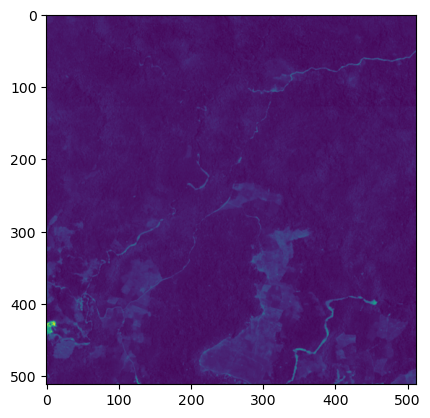

In [18]:
# Show example train image
plt.imshow((np.array(rxr.open_rasterio(r"{}training/images/{}".format(base_dir2,training_images_list2[30])))[0,:,:]))

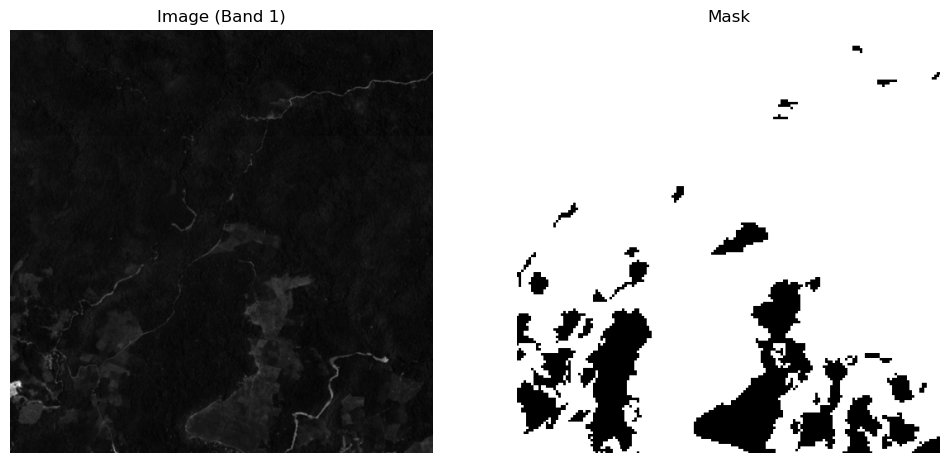

In [17]:
# Displaying image with mask to see if they mapped correctly

idx = 30  # choose which sample to display

img = training_images2[idx][0]        # shape (512, 512, 4)
mask = training_masks2[idx][0]        # shape (512, 512, 1)

plt.figure(figsize=(12,6))

# Image (first band or RGB composite)
plt.subplot(1,2,1)
plt.imshow(img[:,:,], cmap='gray')
plt.title("Image (Band 1)")
plt.axis('off')

# Mask
plt.subplot(1,2,2)
plt.imshow(mask[:,:,], cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.show()

In [19]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [20]:
# Create TensorFlow datasets for training and validation sets
train_df_sumatra = tf.data.Dataset.from_tensor_slices((training_images2, training_masks2))
validation_df_sumatra = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

2025-12-11 01:10:27.757020: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-11 01:10:34.893813: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-11 01:10:34.897245: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## 4-band Kalimantan dataset

In [21]:
base_dir3 = r"./data/kalimantan/"

In [22]:
# Ingest images and normalise
warnings.filterwarnings('ignore', message='.*geotransform.*')

## Training images
training_images_list3 = os.listdir(r"{}training/images/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}training/images/{}".format(base_dir3,n))))
  a = a.astype('float32')
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}training/masks/{}".format(base_dir3,n))))
  a = a.astype('float32')
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}testing/images/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}testing/images/{}".format(base_dir3,n))))
  a = a.astype('float32')
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}testing/masks/{}".format(base_dir3,n))))
  a = a.astype('float32')
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}validation/images/{}".format(base_dir3,n))))
  a = a.astype('float32')
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}validation/masks/{}".format(base_dir3,n))))
  a = a.astype('float32')
  validation_masks3.append(a)

In [23]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

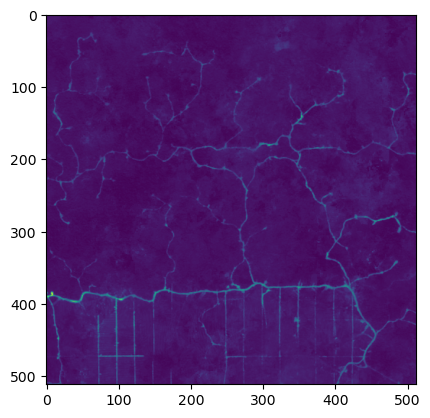

In [82]:
# Plot example training image first band
plt.imshow(training_images3[58].reshape(512,512,4)[:,:,0])

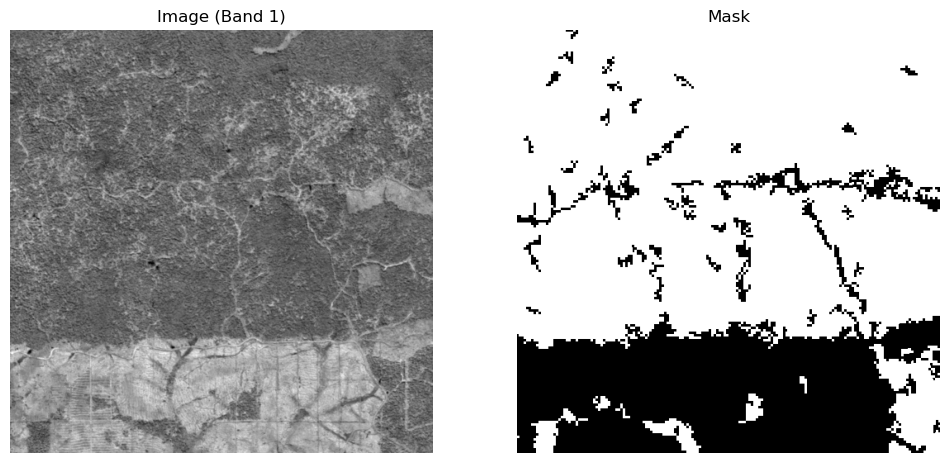

In [83]:
# Displaying image with mask to see if they mapped correctly

idx = 58  # choose which sample to display

img = training_images3[idx][0]        # shape (512, 512, 4)
mask = training_masks3[idx][0]        # shape (512, 512, 1)

plt.figure(figsize=(12,6))

# Image (first band or RGB composite)
plt.subplot(1,2,1)
plt.imshow(img[:,:,3], cmap='gray')
plt.title("Image (Band 1)")
plt.axis('off')

# Mask
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0], cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.show()

In [24]:
## Create TensorFlow datasets for training and validation sets
train_df_kalimantan = tf.data.Dataset.from_tensor_slices((training_images3, training_masks3))
validation_df_kalimantan = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

# Models

## Attention U-Net

In [29]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [30]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(1, 512, 512, 3)]           0         []                            
                                                                                                  
 conv2d_61 (Conv2D)          (1, 512, 512, 16)            448       ['input_3[0][0]']             
                                                                                                  
 activation_53 (Activation)  (1, 512, 512, 16)            0         ['conv2d_61[0][0]']           
                                                                                                  
 conv2d_62 (Conv2D)          (1, 512, 512, 16)            2320      ['activation_53[0][0]']       
                                                                                            

## Attention U-Net Adapted

In [31]:
from tensorflow.keras.regularizers import l2
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock3(input_tensor, filters, kernel_size=3, act='relu', l2_reg=1e-4):
    """Convolutional block with two conv layers, Batch Norm, and L2 Regularization."""
    # First Conv
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal',
               kernel_regularizer=l2(l2_reg))(input_tensor) # Added L2
    x = BatchNormalization()(x) # Added Batch Norm
    x = Activation(act)(x)
    
    # Second Conv
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal',
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    return x

  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAMAdapted(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    conv0 = Dropout(drop_rate)(conv)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock3(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock3(pool0, 4 * filter_base, 3)
    conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock3(pool1, 8 * filter_base, 3)
    conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock3(pool2, 16 * filter_base, 3)
    conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock3(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock3(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock3(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock3(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock3(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model


In [32]:
# Print model layers and number of parameters
UNetAMAdapted().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(1, 512, 512, 3)]           0         []                            
                                                                                                  
 conv2d_92 (Conv2D)          (1, 512, 512, 16)            448       ['input_4[0][0]']             
                                                                                                  
 activation_80 (Activation)  (1, 512, 512, 16)            0         ['conv2d_92[0][0]']           
                                                                                                  
 conv2d_93 (Conv2D)          (1, 512, 512, 16)            2320      ['activation_80[0][0]']       
                                                                                            

# Train

## Train on Sumatra data

In [37]:
# Save model history
np.save('unet-sumatra-history.npy',model_unet_sumatra.history.history)

### Attention U-Net

In [ ]:
# Train U-Net with generator
model_attention_unet_sumatra = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_attention_sumatra = ModelCheckpoint('unet-attention-sumatra.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_sumatra.fit(train_df_sumatra, epochs = 60, validation_data = validation_df_sumatra, callbacks=[save_model_sumatra])

In [39]:
# Save model history
np.save('unet-attention-sumatra-history.npy',model_attention_unet_sumatra.history.history)

### Attention U-Net Adapted

In [33]:
# Train U-Net with generator
model_attention_unet_adapted_sumatra = UNetAMAdapted(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_attention_adapted_sumatra = ModelCheckpoint('unet-attention-adapted-sumatra.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_adapted_sumatra.fit(train_df_sumatra, epochs = 60, validation_data = validation_df_sumatra, callbacks=[save_model_attention_adapted_sumatra])

Epoch 1/60


2025-12-11 01:30:44.571589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-12-11 01:30:46.080719: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2025-12-11 01:31:06.918311: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa21b2eebe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-11 01:31:06.918336: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-12-11 01:31:06.944678: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765416667.092991   16187 device_compiler.h:186] Compiled cluster using XLA!  This line is

250/250 [==============================] - ETA: 0s - loss: 0.8748 - accuracy: 0.6318 - mse: 0.2361
Epoch 1: val_accuracy improved from -inf to 0.59403, saving model to unet-attention-adapted-sumatra.hdf5


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 58s 76ms/step - loss: 0.8748 - accuracy: 0.6318 - mse: 0.2361 - val_loss: 0.7532 - val_accuracy: 0.5940 - val_mse: 0.2211
Epoch 2/60
250/250 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.6441 - mse: 0.2251
Epoch 2: val_accuracy improved from 0.59403 to 0.72724, saving model to unet-attention-adapted-sumatra.hdf5
250/250 [==============================] - 17s 66ms/step - loss: 0.7331 - accuracy: 0.6441 - mse: 0.2251 - val_loss: 0.6226 - val_accuracy: 0.7272 - val_mse: 0.1864
Epoch 3/60
250/250 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.6559 - mse: 0.2202
Epoch 3: val_accuracy did not improve from 0.72724
250/250 [==============================] - 16s 65ms/step - loss: 0.6875 - accuracy: 0.6559 - mse: 0.2202 - val_loss: 0.5731 - val_accuracy: 0.7224 - val_mse: 0.1767
Epoch 4/60
250/250 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.6678 - mse: 0.2160
Epoch 4: val_acc

In [34]:
# Save model history
np.save('unet-attention-adapted-sumatra-history.npy',model_attention_unet_adapted_sumatra.history.history)

## Train on Kalimantan data

### Attention U-Net

In [56]:
# Train Attention U-Net with generator
model_attention_unet_kalimantan = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_attention_kalimantan = ModelCheckpoint('unet-attention-kalimantan.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_kalimantan.fit(train_df_kalimantan, epochs = 60, validation_data = validation_df_kalimantan, callbacks=[save_model_attention_kalimantan])

Epoch 1/60
249/250 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.6502 - mse: 0.2277
Epoch 1: val_accuracy improved from -inf to 0.65533, saving model to unet-attention-kalimantan.hdf5
250/250 [==============================] - 17s 41ms/step - loss: 0.6566 - accuracy: 0.6481 - mse: 0.2282 - val_loss: 0.6359 - val_accuracy: 0.6553 - val_mse: 0.2215


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/60
249/250 [============================>.] - ETA: 0s - loss: 0.6376 - accuracy: 0.6553 - mse: 0.2192
Epoch 2: val_accuracy did not improve from 0.65533
250/250 [==============================] - 10s 39ms/step - loss: 0.6388 - accuracy: 0.6532 - mse: 0.2198 - val_loss: 0.7243 - val_accuracy: 0.6552 - val_mse: 0.2156
Epoch 3/60
249/250 [============================>.] - ETA: 0s - loss: 0.6338 - accuracy: 0.6553 - mse: 0.2195
Epoch 3: val_accuracy did not improve from 0.65533
250/250 [==============================] - 10s 39ms/step - loss: 0.6349 - accuracy: 0.6532 - mse: 0.2200 - val_loss: 0.6293 - val_accuracy: 0.6553 - val_mse: 0.2180
Epoch 4/60
249/250 [============================>.] - ETA: 0s - loss: 0.6265 - accuracy: 0.6553 - mse: 0.2171
Epoch 4: val_accuracy did not improve from 0.65533
250/250 [==============================] - 10s 39ms/step - loss: 0.6276 - accuracy: 0.6533 - mse: 0.2176 - val_loss: 0.6227 - val_accuracy: 0.6553 - val_mse: 0.2165
Epoch 5/60
249/250 [==

In [57]:
# Save model history
np.save('unet-attention-kalimantan-history.npy',model_attention_unet_kalimantan.history.history)

### Attention U-Net Adapted

In [35]:
# Train Attention U-Net with generator
model_attention_unet_adapted_kalimantan = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_attention_adapted_kalimantan = ModelCheckpoint('unet-attention-adapted-kalimantan.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_adapted_kalimantan.fit(train_df_kalimantan, epochs = 60, validation_data = validation_df_kalimantan, callbacks=[save_model_attention_adapted_kalimantan])

Epoch 1/60
249/250 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6334 - mse: 0.2325
Epoch 1: val_accuracy improved from -inf to 0.65531, saving model to unet-attention-adapted-kalimantan.hdf5
250/250 [==============================] - 19s 42ms/step - loss: 0.6601 - accuracy: 0.6314 - mse: 0.2329 - val_loss: 0.6345 - val_accuracy: 0.6553 - val_mse: 0.2213
Epoch 2/60
249/250 [============================>.] - ETA: 0s - loss: 0.6406 - accuracy: 0.6553 - mse: 0.2212
Epoch 2: val_accuracy improved from 0.65531 to 0.65532, saving model to unet-attention-adapted-kalimantan.hdf5
250/250 [==============================] - 10s 40ms/step - loss: 0.6414 - accuracy: 0.6532 - mse: 0.2216 - val_loss: 0.6411 - val_accuracy: 0.6553 - val_mse: 0.2247
Epoch 3/60
249/250 [============================>.] - ETA: 0s - loss: 0.6347 - accuracy: 0.6553 - mse: 0.2200
Epoch 3: val_accuracy improved from 0.65532 to 0.65533, saving model to unet-attention-adapted-kalimantan.hdf5
250/250 [=

In [37]:
# Save model history
np.save('unet-attention-adapted-kalimantan-history.npy',model_attention_unet_adapted_kalimantan.history.history)

# Import Models and Compute Metrics

### Sumatra Data

In [38]:
# Load 4-dim models and history stats
attention_unet_sumatra = load_model('unet-attention-sumatra.hdf5')
attention_unet_adapted_sumatra = load_model('unet-attention-adapted-sumatra.hdf5')

attention_unet_adapted_sumatra_history = np.load('unet-attention-adapted-sumatra-history.npy', allow_pickle='TRUE').item()
attention_unet_sumatra_history = np.load('unet-attention-sumatra-history.npy', allow_pickle='TRUE').item()


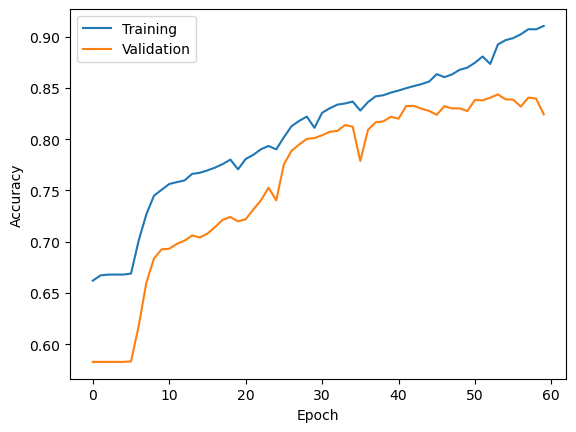

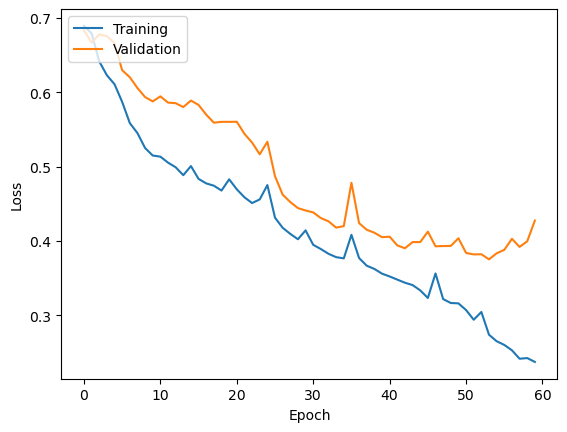

In [39]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_sumatra_history['accuracy'])
plt.plot(attention_unet_sumatra_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_sumatra_history['loss'])
plt.plot(attention_unet_sumatra_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

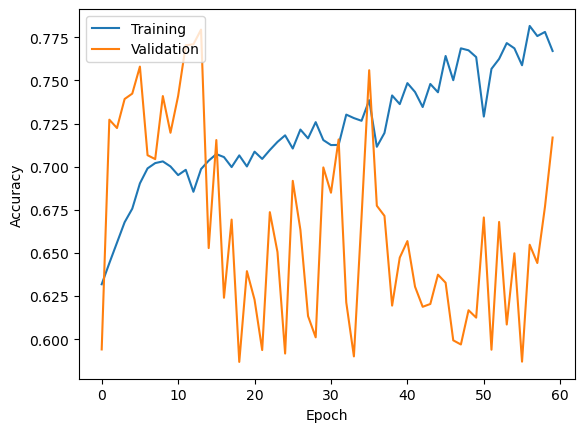

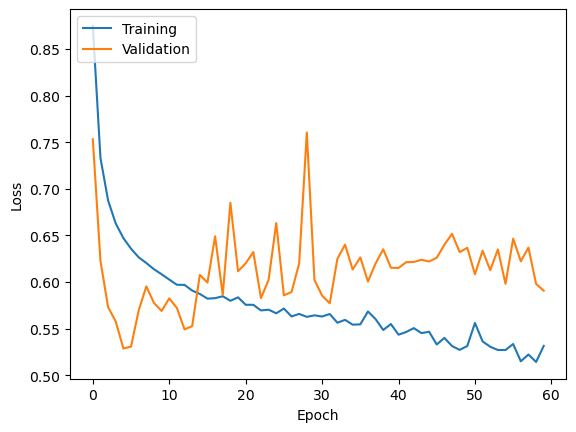

In [40]:
# Plot accuracy and loss for Attention U-Net Adapted

## Accuracy
plt.plot(attention_unet_adapted_sumatra_history['accuracy'])
plt.plot(attention_unet_adapted_sumatra_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_adapted_sumatra_history['loss'])
plt.plot(attention_unet_adapted_sumatra_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [41]:
# Scores of each model
am_unet_adapted_sumatra_score = (score_eval2(attention_unet_adapted_sumatra, validation_images2, validation_masks2))
am_unet_sumatra_score = (score_eval2(attention_unet_sumatra, validation_images2, validation_masks2))

1/1 [==============================] - 0s 23ms/step


In [42]:
# Precision and recall of each model
am_unet_adapted_sumatra_precision = (precision_eval(attention_unet_adapted_sumatra, validation_images2, validation_masks2))
am_unet_sumatra_precision = (precision_eval(attention_unet_sumatra, validation_images2, validation_masks2))

am_unet_adapted_sumatra_recall = (recall_eval(attention_unet_adapted_sumatra, validation_images2, validation_masks2))
am_unet_sumatra_recall = (recall_eval(attention_unet_sumatra, validation_images2, validation_masks2))

1/1 [==============================] - 0s 23ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 23ms/step


In [43]:
# F1-scores of each model
am_unet_sumatra_f1_score = (f1_score_eval_basic(am_unet_sumatra_precision, am_unet_sumatra_recall))

In [44]:
# Print score eval results for each model
print('Attention U-Net accuracy: ', np.mean(am_unet_sumatra_score), np.std(am_unet_sumatra_score))

Attention U-Net adapted accuracy:  0.7794759923761542 0.1699081294666959
Attention U-Net accuracy:  0.8436563231728293 0.11658925311362003


In [45]:
# Print precision eval results for each model
print('Attention U-Net precision: ', np.mean(am_unet_sumatra_precision), np.std(am_unet_sumatra_precision))

Attention U-Net adapted adapted precision:  0.8961130125021516 0.07181002794806303
Attention U-Net precision:  0.8876424488070377 0.0774519595425351


In [46]:
# Print recall eval results for each model
print('Attention U-Net recall: ', np.mean(am_unet_sumatra_recall), np.std(am_unet_sumatra_recall))

Attention U-Net adapted recall:  0.7794759923761542 0.1699081294666959
Attention U-Net recall:  0.8436563231728293 0.11658925311362003


In [47]:
# Print f1-score eval results for each model
print('Attention U-Net F1-score: ', np.mean(am_unet_sumatra_f1_score))

Attention U-Net adapted F1-score:  0.8337349763786855
Attention U-Net F1-score:  0.8650906207208704


### Sumatra model on unseen Kalimantan data

In [50]:
# Score
am_unet_sumatra_on_kalimantan_score = score_eval2(attention_unet_sumatra, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
am_unet_sumatra_on_kalimantan_precision = (precision_eval(attention_unet_sumatra, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
am_unet_sumatra_on_kalimantan_recall = (recall_eval(attention_unet_sumatra, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
am_unet_sumatra_on_kalimantan_f1_score = (f1_score_eval_basic(am_unet_sumatra_on_kalimantan_precision, am_unet_sumatra_on_kalimantan_recall))

1/1 [==============================] - 0s 23ms/step


NameError: name 'precision_eval2' is not defined

In [51]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_sumatra_on_kalimantan_score), np.std(am_unet_sumatra_on_kalimantan_score))

print('Attention U-Net precision: ', np.mean(am_unet_sumatra_on_kalimantan_precision), np.std(am_unet_sumatra_on_kalimantan_precision))

print('Attention U-Net recall: ', np.mean(am_unet_sumatra_on_kalimantan_recall), np.std(am_unet_sumatra_on_kalimantan_recall))

print('Attention U-Net F1-score: ', am_unet_sumatra_on_kalimantan_f1_score)

Attention U-Net score:  0.7576735608931277 0.18265003315271547
Attention U-Net precision:  0.7961544556618014 0.13206191345680957
Attention U-Net recall:  0.7576735608931277 0.18265003315271547
Attention U-Net F1-score:  0.7764375143391326


### Kalimantan Data

In [58]:
# Load 4-dim models and history stats
attention_unet_kalimantan = load_model('unet-attention-kalimantan.hdf5')
unet_adapted_kalimantan = load_model('unet-attention-adapted-kalimantan.hdf5')

unet_adapted_kalimantan_history = np.load('unet-attention-adapted-kalimantan-history.npy', allow_pickle='TRUE').item()
attention_unet_kalimantan_history = np.load('unet-attention-kalimantan-history.npy', allow_pickle='TRUE').item()

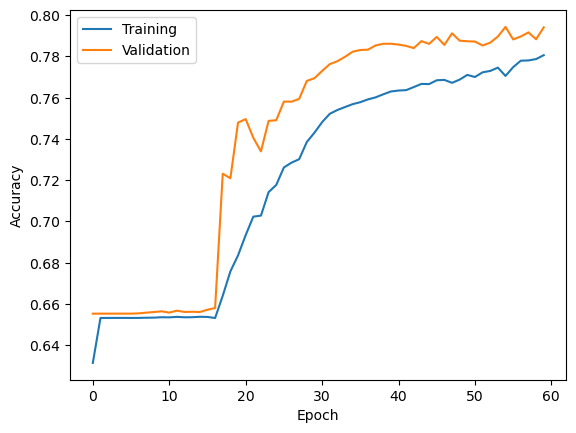

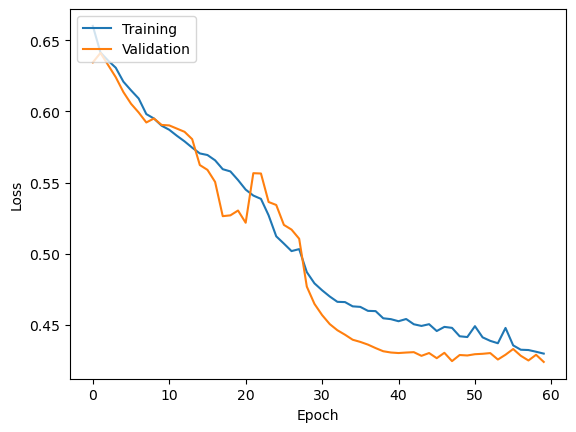

In [59]:
# Plot accuracy and loss for adapted model

## Accuracy
plt.plot(unet_adapted_kalimantan_history['accuracy'])
plt.plot(unet_adapted_kalimantan_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_adapted_kalimantan_history['loss'])
plt.plot(unet_adapted_kalimantan_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

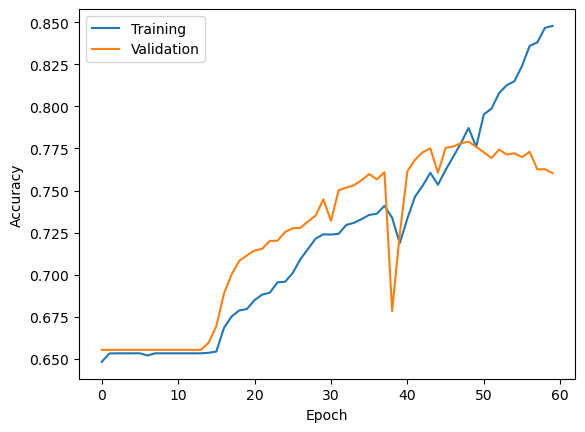

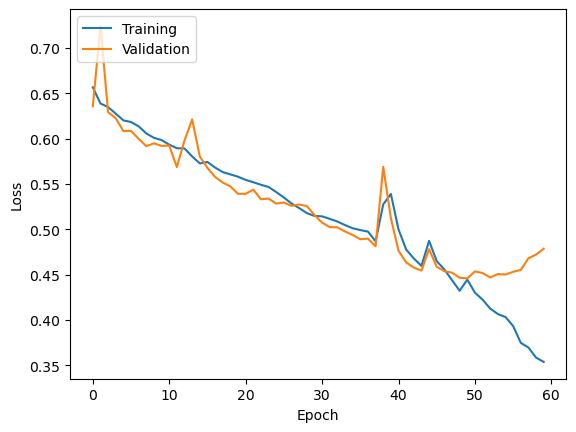

In [60]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_kalimantan_history['accuracy'])
plt.plot(attention_unet_kalimantan_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_kalimantan_history['loss'])
plt.plot(attention_unet_kalimantan_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [96]:
# Scores of each model
am_unet_kalimantan_score = (score_eval2(attention_unet_kalimantan, validation_images3, validation_masks3))
unet_adapted_kalimantan_score = (score_eval2(unet_adapted_kalimantan, validation_images3, validation_masks3))

# Precision and recall of each model
am_unet_kalimantan_precision = (precision_eval(attention_unet_kalimantan, validation_images3, validation_masks3))
unet_adapted_kalimantan_precision = (precision_eval(unet_adapted_kalimantan, validation_images3, validation_masks3))

am_unet_kalimantan_recall = (recall_eval(attention_unet_kalimantan, validation_images3, validation_masks3))
unet_adapted_kalimantan_recall = (recall_eval(unet_adapted_kalimantan, validation_images3, validation_masks3))

# F1-scores of each model
am_unet_kalimantan_f1_score = (f1_score_eval_basic(am_unet_kalimantan_precision, am_unet_kalimantan_recall))
unet_adapted_kalimantan_f1_score = (f1_score_eval_basic(unet_adapted_kalimantan_precision, unet_adapted_kalimantan_recall))

1/1 [==============================] - 0s 27ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 26ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 26ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 25ms/step


In [97]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_kalimantan_score), np.std(am_unet_kalimantan_score))
print('Attention U-Net adapted score: ', np.mean(unet_adapted_kalimantan_score), np.std(unet_adapted_kalimantan_score))

print('Attention U-Net precision: ', np.mean(am_unet_kalimantan_precision), np.std(am_unet_kalimantan_precision))
print('Attention U-Net adapted precision: ', np.mean(unet_adapted_kalimantan_precision), np.std(unet_adapted_kalimantan_precision))

print('Attention U-Net recall: ', np.mean(am_unet_kalimantan_recall), np.std(am_unet_kalimantan_recall))
print('Attention U-Net adapted recall: ', np.mean(unet_adapted_kalimantan_recall), np.std(unet_adapted_kalimantan_recall))

print('Attention U-Net F1-score: ', am_unet_kalimantan_f1_score)
print('Attention U-Net adapted F1-score: ', np.mean(unet_adapted_kalimantan_f1_score), np.std(unet_adapted_kalimantan_f1_score))

Attention U-Net score:  0.7789845099815955 0.1209011883051271
Attention U-Net adapted score:  0.7943031897911659 0.11294899721691415
Attention U-Net precision:  0.826135977723478 0.10578147603221712
Attention U-Net adapted precision:  0.846330508211021 0.09400585447592325
Attention U-Net recall:  0.7789845099815955 0.1209011883051271
Attention U-Net adapted recall:  0.7943031897911659 0.11294899721691415
Attention U-Net F1-score:  0.8018676911976914
Attention U-Net adapted F1-score:  0.8194919110928762 0.0


### Kalimantan on unseen sumatra data

In [98]:
# Score
am_unet_kalimantan_on_sumatra_score = score_eval2(attention_unet_kalimantan, validation_images2+test_images2, validation_masks2+test_masks2)
am_unet_adapted_kalimantan_on_sumatra_score = score_eval2(unet_adapted_kalimantan, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
am_unet_kalimantan_on_sumatra_precision = (precision_eval(attention_unet_kalimantan, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_adapted_kalimantan_on_sumatra_precision = (precision_eval(unet_adapted_kalimantan, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
am_unet_kalimantan_on_sumatra_recall = (recall_eval(attention_unet_kalimantan, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_adapted_kalimantan_on_sumatra_recall = (recall_eval(unet_adapted_kalimantan, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
am_unet_kalimantan_on_sumatra_f1_score = (f1_score_eval_basic(am_unet_kalimantan_on_sumatra_precision, am_unet_kalimantan_on_sumatra_recall))
am_unet_adapted_kalimantan_on_sumatra_f1_score = (f1_score_eval_basic(am_unet_adapted_kalimantan_on_sumatra_precision, am_unet_adapted_kalimantan_on_sumatra_recall))

1/1 [==============================] - 0s 27ms/step


In [100]:
# Print metrics
print('Attention U-Net score: ', np.mean(am_unet_kalimantan_on_sumatra_score), np.std(am_unet_kalimantan_on_sumatra_score))
print('Attention U-Net Adapted score: ', np.mean(am_unet_adapted_kalimantan_on_sumatra_score), np.std(am_unet_adapted_kalimantan_on_sumatra_score))

print('Attention U-Net precision: ', np.mean(am_unet_kalimantan_on_sumatra_precision), np.std(am_unet_kalimantan_on_sumatra_precision))
print('Attention U-Net Adapted precision: ', np.mean(am_unet_adapted_kalimantan_on_sumatra_precision), np.std(am_unet_adapted_kalimantan_on_sumatra_precision))

print('Attention U-Net recall: ', np.mean(am_unet_kalimantan_on_sumatra_recall), np.std(am_unet_kalimantan_on_sumatra_recall))
print('Attention U-Net Adapted recall: ', np.mean(am_unet_adapted_kalimantan_on_sumatra_recall), np.std(am_unet_adapted_kalimantan_on_sumatra_recall))

print('Attention U-Net F1-score: ', am_unet_kalimantan_on_sumatra_f1_score)
print('Attention U-Net Adapted F1-score: ', am_unet_adapted_kalimantan_on_sumatra_f1_score)

Attention U-Net score:  0.7919113794962566 0.13654975538156627
Attention U-Net Adapted score:  0.7971293131510416 0.14783510100298788
Attention U-Net precision:  0.8810594640469089 0.08271977318996915
Attention U-Net Adapted precision:  0.8780240586783209 0.0884315000380411
Attention U-Net recall:  0.7919113794962566 0.13654975538156627
Attention U-Net Adapted recall:  0.7971293131510416 0.14783510100298788
Attention U-Net F1-score:  0.8341101917997865
Attention U-Net Adapted F1-score:  0.8356234439118977


### Sumatra and Kalimantan unseen test data

In [65]:
# sumatra trained model on sumatra test data
# Scores of each model
am_unet_sumatra_score_test = (score_eval2(attention_unet_sumatra, test_images2, test_masks2))

# Precision and recall of each model
am_unet_sumatra_precision_test = (precision_eval(attention_unet_sumatra, test_images2, test_masks2))

am_unet_sumatra_recall_test = (recall_eval(attention_unet_sumatra, test_images2, test_masks2))

# F1-scores of each model
am_unet_sumatra_f1_score_test = (f1_score_eval_basic(am_unet_sumatra_precision_test, am_unet_sumatra_recall_test))

1/1 [==============================] - 0s 22ms/step


In [102]:
# Kalimantan trained model on Kalimantan test data
# Scores of each model
am_unet_kalimantan_score_test = (score_eval2(attention_unet_kalimantan, test_images3, test_masks3))
am_unet_adapted_kalimantan_score_test = (score_eval2(unet_adapted_kalimantan, test_images3, test_masks3))

# Precision and recall of each model
am_unet_kalimantan_precision_test = (precision_eval(attention_unet_kalimantan, test_images3, test_masks3))
am_unet_adapted_kalimantan_precision_test = (precision_eval(unet_adapted_kalimantan, test_images3, test_masks3))

am_unet_kalimantan_recall_test = (recall_eval(attention_unet_kalimantan, test_images3, test_masks3))
am_unet_adapted_kalimantan_recall_test = (recall_eval(unet_adapted_kalimantan, test_images3, test_masks3))

# F1-scores of each model
am_unet_kalimantan_f1_score_test = (f1_score_eval_basic(am_unet_kalimantan_precision_test, am_unet_kalimantan_recall_test))
am_unet_adapted_kalimantan_f1_score_test = (f1_score_eval_basic(am_unet_adapted_kalimantan_precision_test, am_unet_adapted_kalimantan_recall_test))

1/1 [==============================] - 0s 24ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 25ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 24ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 25ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 24ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 25ms/step


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 27ms/step


In [106]:
# Print metrics for Sumatra on Sumatra Test set
print('Attention U-Net score: ', np.mean(am_unet_sumatra_score_test), np.std(am_unet_sumatra_score_test))

print('Attention U-Net precision: ', np.mean(am_unet_sumatra_precision_test), np.std(am_unet_sumatra_precision_test))

print('Attention U-Net recall: ', np.mean(am_unet_sumatra_recall_test), np.std(am_unet_sumatra_recall_test))

print('Attention U-Net F1-score: ', am_unet_sumatra_f1_score_test)

Attention U-Net score:  0.8507675087970236 0.10633092090496113
Attention U-Net precision:  0.882929096153685 0.08060283031650735
Attention U-Net recall:  0.8507675087970236 0.10633092090496113
Attention U-Net F1-score:  0.8665499896972284


In [107]:
# Print metrics for Kalimantan on Kalimantan Test set
print('Attention U-Net score: ', np.mean(am_unet_kalimantan_score_test), np.std(am_unet_kalimantan_score_test))
print('Attention U-Net Adapted score: ', np.mean(am_unet_adapted_kalimantan_score_test), np.std(am_unet_adapted_kalimantan_score_test))

print('Attention U-Net precision: ', np.mean(am_unet_kalimantan_precision_test), np.std(am_unet_kalimantan_precision_test))
print('Attention U-Net Adapted precision: ', np.mean(am_unet_adapted_kalimantan_precision_test), np.std(am_unet_adapted_kalimantan_precision_test))

print('Attention U-Net recall: ', np.mean(am_unet_kalimantan_recall_test), np.std(am_unet_kalimantan_recall_test))
print('Attention U-Net Adapted recall: ', np.mean(am_unet_adapted_kalimantan_recall_test), np.std(am_unet_adapted_kalimantan_recall_test))

print('Attention U-Net F1-score: ', am_unet_kalimantan_f1_score_test)
print('Attention U-Net Adapted F1-score: ', am_unet_adapted_kalimantan_f1_score_test)

Attention U-Net score:  0.780901801317258 0.12368062350512539
Attention U-Net Adapted score:  0.792721454362224 0.12239167536282747
Attention U-Net precision:  0.8068563781857063 0.12712826801989033
Attention U-Net Adapted precision:  0.8321368590934293 0.11497263180124484
Attention U-Net recall:  0.780901801317258 0.12368062350512539
Attention U-Net Adapted recall:  0.792721454362224 0.12239167536282747
Attention U-Net F1-score:  0.7936669541539093
Attention U-Net Adapted F1-score:  0.8119510922352924


# Produce metric datasets for export

## Sumatra data

In [69]:
scores_sumatra = [am_unet_sumatra_score]
precision_sumatra = [am_unet_sumatra_precision]
recall_sumatra = [am_unet_sumatra_recall]
f1_scores_sumatra = [am_unet_sumatra_f1_score]

metrics_sumatra = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_sumatra],
              'precision': [np.mean(n) for n in precision_sumatra],
              'recall': [np.mean(n) for n in recall_sumatra],
              'f1_score': [np.mean(n) for n in f1_scores_sumatra],
              'accuracy_std': [np.std(n) for n in scores_sumatra],
              'precision_std': [np.std(n) for n in precision_sumatra],
              'recall_std': [np.std(n) for n in recall_sumatra]
              }
metrics_sumatra = pd.DataFrame(metrics_sumatra)
metrics_sumatra.to_csv('metrics_sumatra.csv')

## Kalimantan data

In [71]:
scores_kalimantan = [am_unet_kalimantan_score]
precision_kalimantan = [am_unet_kalimantan_precision]
recall_kalimantan = [am_unet_kalimantan_recall]
f1_scores_kalimantan = [am_unet_kalimantan_f1_score]

metrics_kalimantan = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_kalimantan],
              'precision': [np.mean(n) for n in precision_kalimantan],
              'recall': [np.mean(n) for n in recall_kalimantan],
              'f1_score': [np.mean(n) for n in f1_scores_kalimantan],
              'accuracy_std': [np.std(n) for n in scores_kalimantan],
              'precision_std': [np.std(n) for n in precision_kalimantan],
              'recall_std': [np.std(n) for n in recall_kalimantan]
              }
metrics_kalimantan = pd.DataFrame(metrics_kalimantan)
metrics_kalimantan.to_csv('metrics_kalimantan.csv')

## Test set data

In [75]:
scores_sumatra_test = [am_unet_sumatra_score_test]
precision_sumatra_test = [am_unet_sumatra_precision_test]
recall_sumatra_test = [am_unet_sumatra_recall_test]
f1_scores_sumatra_test = [am_unet_sumatra_f1_score_test]

metrics_sumatra_test = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_sumatra_test],
              'precision': [np.mean(n) for n in precision_sumatra_test],
              'recall': [np.mean(n) for n in recall_sumatra_test],
              'f1_score': [np.mean(n) for n in f1_scores_sumatra_test],
              'accuracy_std': [np.std(n) for n in scores_sumatra_test],
              'precision_std': [np.std(n) for n in precision_sumatra_test],
              'recall_std': [np.std(n) for n in recall_sumatra_test]
              }
metrics_sumatra_test = pd.DataFrame(metrics_sumatra_test)
metrics_sumatra_test.to_csv('metrics_sumatra_test.csv')

In [74]:
scores_kalimantan_test = [am_unet_kalimantan_score_test]
precision_kalimantan_test = [am_unet_kalimantan_precision_test]
recall_kalimantan_test = [am_unet_kalimantan_recall_test]
f1_scores_kalimantan_test = [am_unet_kalimantan_f1_score_test]

metrics_kalimantan_test = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_kalimantan_test],
              'precision': [np.mean(n) for n in precision_kalimantan_test],
              'recall': [np.mean(n) for n in recall_kalimantan_test],
              'f1_score': [np.mean(n) for n in f1_scores_kalimantan_test],
              'accuracy_std': [np.std(n) for n in scores_kalimantan_test],
              'precision_std': [np.std(n) for n in precision_kalimantan_test],
              'recall_std': [np.std(n) for n in recall_kalimantan_test]
              }
metrics_kalimantan_test = pd.DataFrame(metrics_kalimantan_test)
metrics_kalimantan_test.to_csv('metrics_kalimantan_forest_test.csv')

## Testing on opposite dataset (e.g. train on sumatra, test on Kalimantan)

In [77]:
scores_sumatra_on_kalimantan = [am_unet_sumatra_on_kalimantan_score]
precision_sumatra_on_kalimantan = [am_unet_sumatra_on_kalimantan_precision]
recall_sumatra_on_kalimantan = [am_unet_sumatra_on_kalimantan_recall]
f1_scores_sumatra_on_kalimantan = [am_unet_sumatra_on_kalimantan_f1_score]

metrics_sumatra_on_kalimantan = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_sumatra_on_kalimantan],
              'precision': [np.mean(n) for n in precision_sumatra_on_kalimantan],
              'recall': [np.mean(n) for n in recall_sumatra_on_kalimantan],
              'f1_score': [np.mean(n) for n in f1_scores_sumatra_on_kalimantan],
              'accuracy_std': [np.std(n) for n in scores_sumatra_on_kalimantan],
              'precision_std': [np.std(n) for n in precision_sumatra_on_kalimantan],
              'recall_std': [np.std(n) for n in recall_sumatra_on_kalimantan]
              }
metrics_sumatra_on_kalimantan = pd.DataFrame(metrics_sumatra_on_kalimantan)
metrics_sumatra_on_kalimantan.to_csv('metrics_sumatra_on_kalimantan.csv')

In [78]:
scores_kalimantan_on_sumatra = [am_unet_kalimantan_on_sumatra_score]
precision_kalimantan_on_sumatra = [am_unet_kalimantan_on_sumatra_precision]
recall_kalimantan_on_sumatra = [am_unet_kalimantan_on_sumatra_recall]
f1_scores_kalimantan_on_sumatra = [am_unet_kalimantan_on_sumatra_f1_score]

metrics_kalimantan_on_sumatra = {'classifier': ['Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_kalimantan_on_sumatra],
              'precision': [np.mean(n) for n in precision_kalimantan_on_sumatra],
              'recall': [np.mean(n) for n in recall_kalimantan_on_sumatra],
              'f1_score': [np.mean(n) for n in f1_scores_kalimantan_on_sumatra],
              'accuracy_std': [np.std(n) for n in scores_kalimantan_on_sumatra],
              'precision_std': [np.std(n) for n in precision_kalimantan_on_sumatra],
              'recall_std': [np.std(n) for n in recall_kalimantan_on_sumatra]
              }
metrics_kalimantan_on_sumatra = pd.DataFrame(metrics_kalimantan_on_sumatra)
metrics_kalimantan_on_sumatra.to_csv('metrics_kalimantan_on_sumatra.csv')